# **Q8. LoanTap Logistic Regression**

## **Problem Statement:**
### 1. Help Loantap in understanding what factors are important in predicting possible loan defaulters and how these factors are interrelated among themselves, so as to decide whether to disburse loan to a borrower or not.

In [14]:
install -c conda-forge catboost 

SyntaxError: invalid syntax (1654975949.py, line 1)

In [8]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install category_encoders 
pip install statsmodels


In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import TargetEncoder 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import missingno as msno 

ModuleNotFoundError: No module named 'category_encoders'

In [7]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]
mon_to_int = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
grade_to_int = {'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1}
sub_grade_to_int = {'A1':35, 'A2':34, 'A3':33, 'A4':32, 'A5':31, 
                    'B1':30, 'B2':29, 'B3':28, 'B4':27, 'B5':26, 
                    'C1':25, 'C2':24, 'C3':23, 'C4':22, 'C5':21, 
                    'D1':20, 'D2':19, 'D3':18, 'D4':17, 'D5':16, 
                    'E1':15, 'E2':14, 'E3':13, 'E4':12, 'E5':11, 
                    'F1':10, 'F2':9, 'F3':8, 'F4':7, 'F5':6, 
                    'G1':5, 'G2':4, 'G3':3, 'G4':2, 'G5':1}
emp_len_to_int = {'10+ years': 10, '4 years': 4, '< 1 year': 0, '6 years': 6, '9 years': 9, '2 years': 2, 
                  '3 years': 3, '8 years': 8, '7 years': 7, '5 years': 5, '1 year': 1, 'nan': np.nan}

In [8]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<5:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<5:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [9]:
def remove_outlier(df_in, col_name, thresh=5):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= thresh/100:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

***
***
## **1. Analyzing Basic Metrics.**

In [2]:
import pandas as pd
filename = 'loan_data.csv'
df = pd.read_csv(filename)

ModuleNotFoundError: No module named 'pandas'

In [11]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [12]:
print("Shape:", df.shape, "\n")

Shape: (396030, 27) 



***
***
## **2. Missing Value detection and treatment.**

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [153]:
values = {"emp_title": 'Unknown', "emp_length": '< 1 year', "title": 'Unknown', "revol_util": 0, 'mort_acc': 0, 'pub_rec_bankruptcies': 0}
df = df.fillna(value=values)

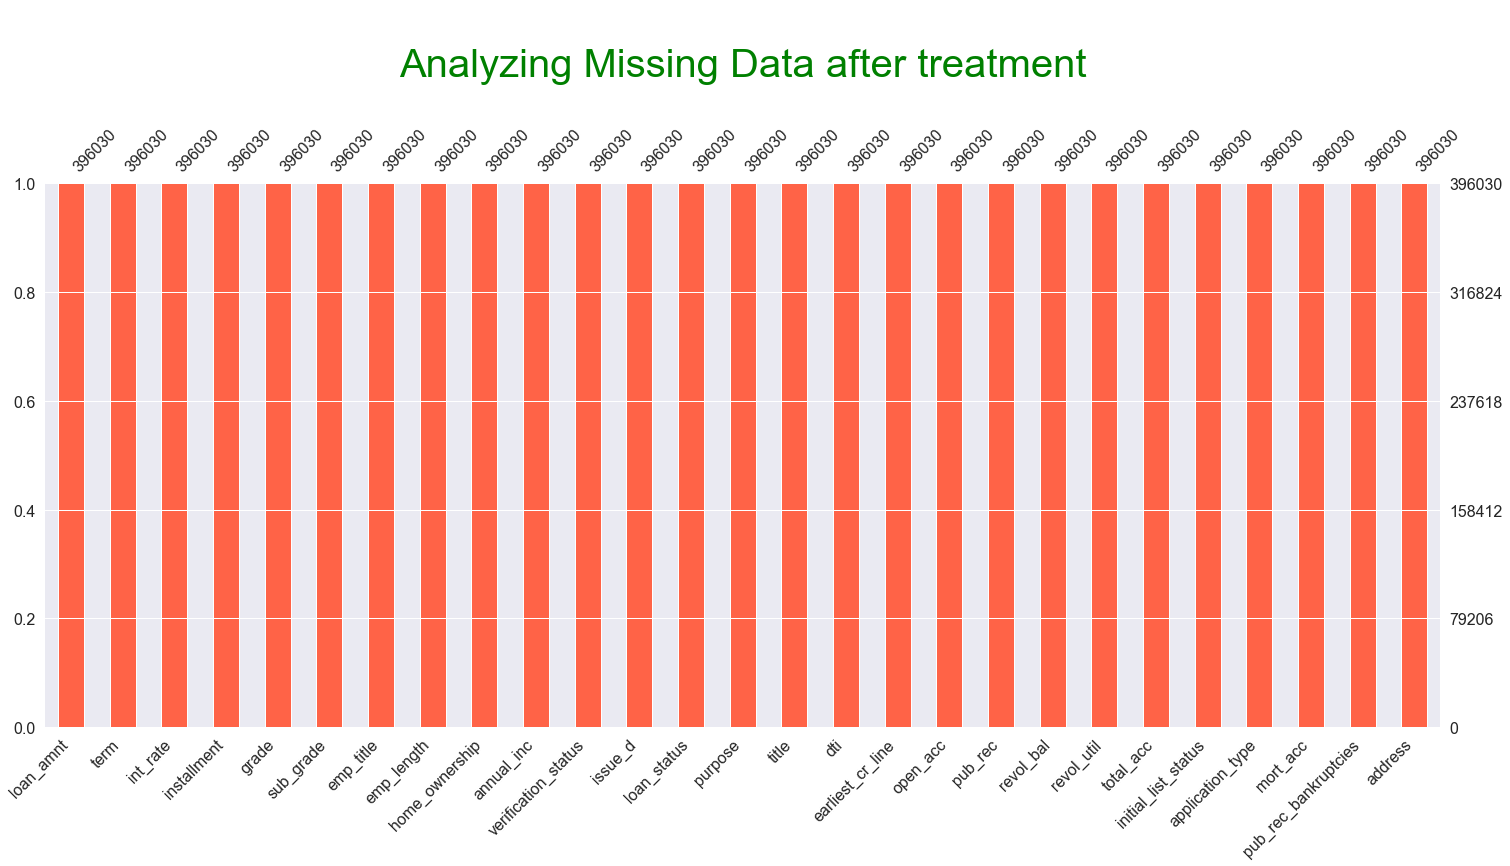

In [154]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data after treatment\n", fontsize=40, color="green")
plt.show()

***
***
## **3. Feature Creation and Feature Transformation.**

In [155]:
for column in ['term', 'grade', 'sub_grade', 'emp_length', 'issue_d', 'earliest_cr_line', 'emp_title', 'address']:
    print(f"\nUnique values in {column} column are: ", df[column].unique()[:30])


Unique values in term column are:  [' 36 months' ' 60 months']

Unique values in grade column are:  ['B' 'A' 'C' 'E' 'D' 'F' 'G']

Unique values in sub_grade column are:  ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1']

Unique values in emp_length column are:  ['10+ years' '4 years' '< 1 year' '6 years' '9 years' '2 years' '3 years'
 '8 years' '7 years' '5 years' '1 year']

Unique values in issue_d column are:  ['Jan-2015' 'Nov-2014' 'Apr-2013' 'Sep-2015' 'Sep-2012' 'Oct-2014'
 'Apr-2012' 'Jun-2013' 'May-2014' 'Dec-2015' 'Apr-2015' 'Oct-2012'
 'Jul-2014' 'Feb-2013' 'Oct-2015' 'Jan-2014' 'Mar-2016' 'Apr-2014'
 'Jun-2011' 'Apr-2010' 'Jun-2014' 'Oct-2013' 'May-2013' 'Feb-2015'
 'Oct-2011' 'Jun-2015' 'Aug-2013' 'Feb-2014' 'Dec-2011' 'Mar-2013']

Unique values in earliest_cr_line column are:  ['Jun-1990' 'Jul-2004' 'Aug-2007' 'Sep-2006' 'Mar-1999' 'Jan-2005'
 'Aug-2005' 'Sep-1994' 'Jun

In [156]:
df['term_months'] = df['term'].apply(lambda x: int(str(x).split(' ')[1]))
df['grade'] = df['grade'].apply(lambda x: grade_to_int[str(x).split('-')[0]])
df['sub_grade'] = df['sub_grade'].apply(lambda x: sub_grade_to_int[str(x).split('-')[0]])
df['emp_length'] = df['emp_length'].apply(lambda x: emp_len_to_int[str(x).split('-')[0]])
df['issue_d_month'] = df['issue_d'].apply(lambda x: mon_to_int[str(x).split('-')[0]])
df['issue_d_year'] = df['issue_d'].apply(lambda x: int(str(x).split('-')[1]))
df['earliest_cr_line_month'] = df['earliest_cr_line'].apply(lambda x: mon_to_int[str(x).split('-')[0]])
df['earliest_cr_line_year'] = df['earliest_cr_line'].apply(lambda x: int(str(x).split('-')[1]))
df['emp_title_primary'] = df['emp_title'].apply(lambda x: str(x).strip().split(':')[0] if ':' in str(x) else str(x))
df['emp_title_secondary'] = df['emp_title'].apply(lambda x: str(x).strip().split(':')[1] if ':' in str(x) else 'NA')
df['title'] = df['title'].apply(lambda x: str(x).replace(':', '').strip())
df['pin_code'] = df['address'].apply(lambda x: str(str(x)[len(str(x))-5:]))
df = df.drop(['term', 'issue_d', 'earliest_cr_line', 'emp_title', 'address'], axis=1)

In [157]:
df.head()

,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,term_months,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,emp_title_primary,emp_title_secondary,pin_code
0,10000.0,11.44,329.48,6,27,10,RENT,117000.0,Not Verified,Fully Paid,vacation,Vacation,26.24,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,36,1,2015,6,1990,Marketing,NA,22690
1,8000.0,11.99,265.68,6,26,4,MORTGAGE,65000.0,Not Verified,Fully Paid,debt_consolidation,Debt consolidation,22.05,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,36,1,2015,7,2004,Credit analyst,NA,05113
2,15600.0,10.49,506.97,6,28,0,RENT,43057.0,Source Verified,Fully Paid,credit_card,Credit card refinancing,12.79,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,36,1,2015,8,2007,Statistician,NA,05113
3,7200.0,6.49,220.65,7,34,6,RENT,54000.0,Not Verified,Fully Paid,credit_card,Credit card refinancing,2.60,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,36,11,2014,9,2006,Client Advocate,NA,00813
4,24375.0,17.27,609.33,5,21,9,MORTGAGE,55000.0,Verified,Charged Off,credit_card,Credit Card Refinance,33.95,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,60,4,2013,3,1999,Destiny Management Inc.,NA,11650


In [158]:
print("Shape:", df.shape, "\n")

Shape: (396030, 30) 



In [159]:
df = convert_to_best_type(df)
df['pin_code'] = df['pin_code'].astype('string')
df.dtypes

loan_amnt                  float64
int_rate                   float64
installment                float64
grade                        int64
sub_grade                    int64
emp_length                   int64
home_ownership              string
annual_inc                 float64
verification_status       category
loan_status               category
purpose                     string
title                       string
dti                        float64
open_acc                   float64
pub_rec                    float64
revol_bal                  float64
revol_util                 float64
total_acc                  float64
initial_list_status       category
application_type          category
mort_acc                   float64
pub_rec_bankruptcies       float64
term_months               category
issue_d_month                int64
issue_d_year                 int64
earliest_cr_line_month       int64
earliest_cr_line_year        int64
emp_title_primary           string
emp_title_secondary 

***
***
## **4. Outlier Detection & Treatment.**

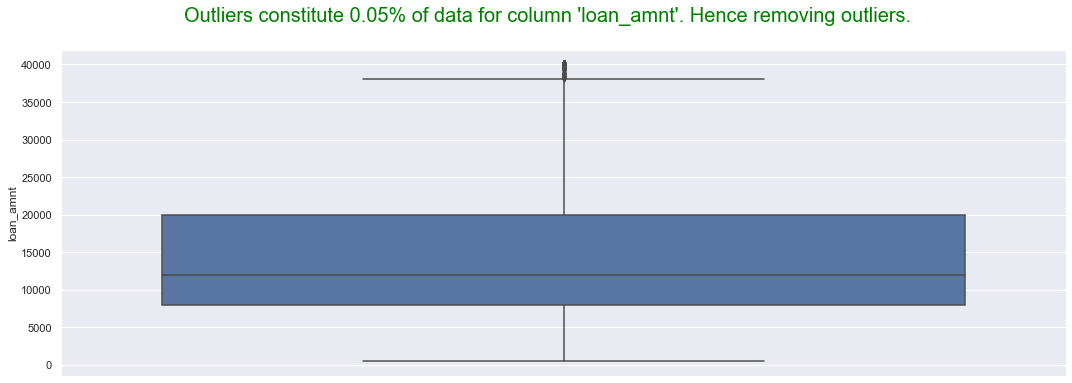

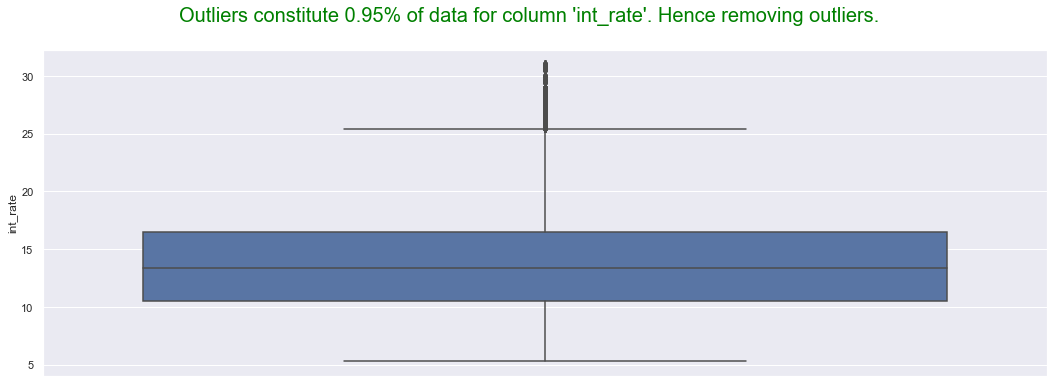

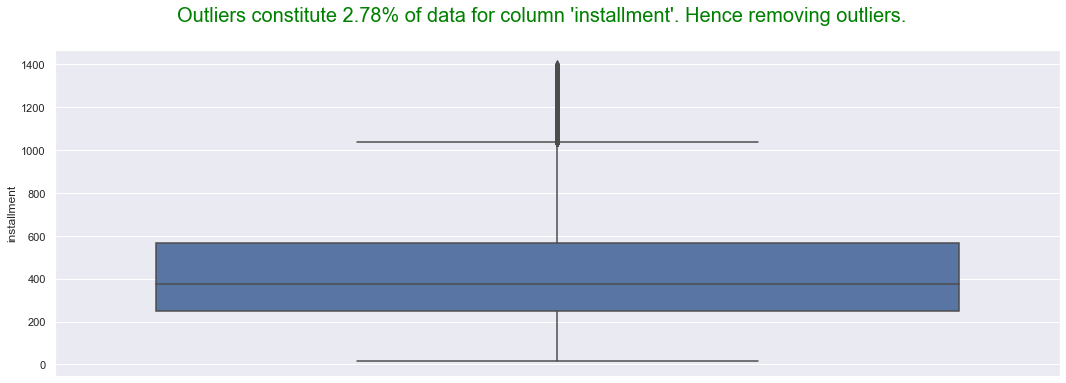

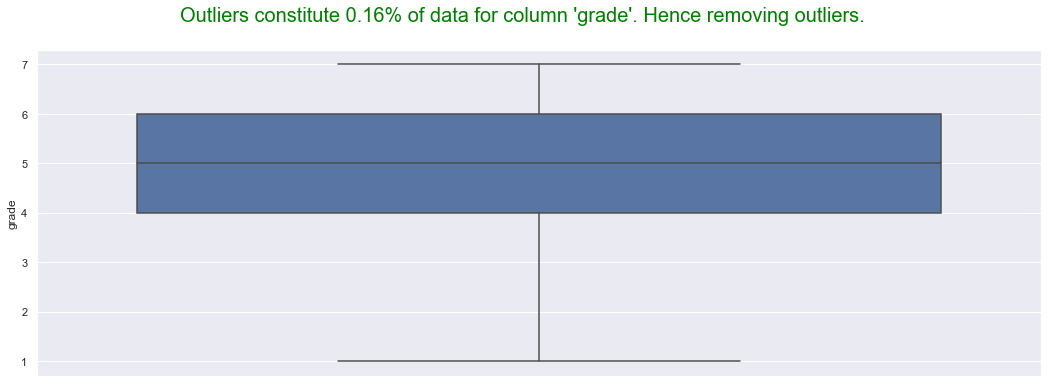

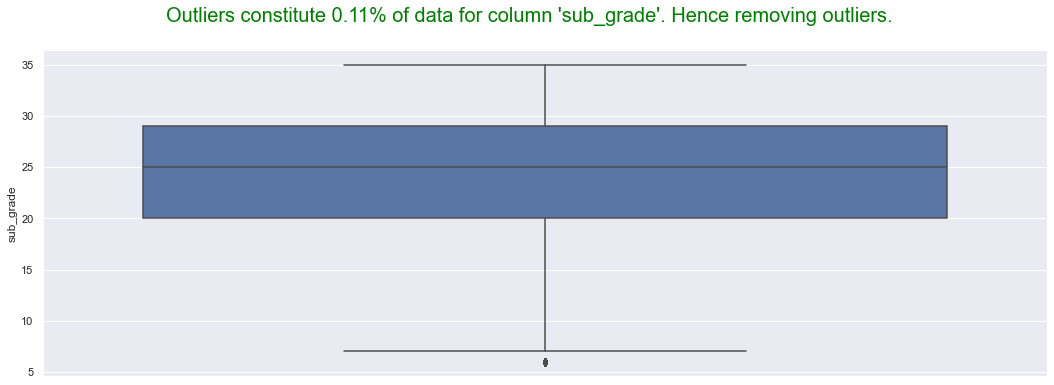

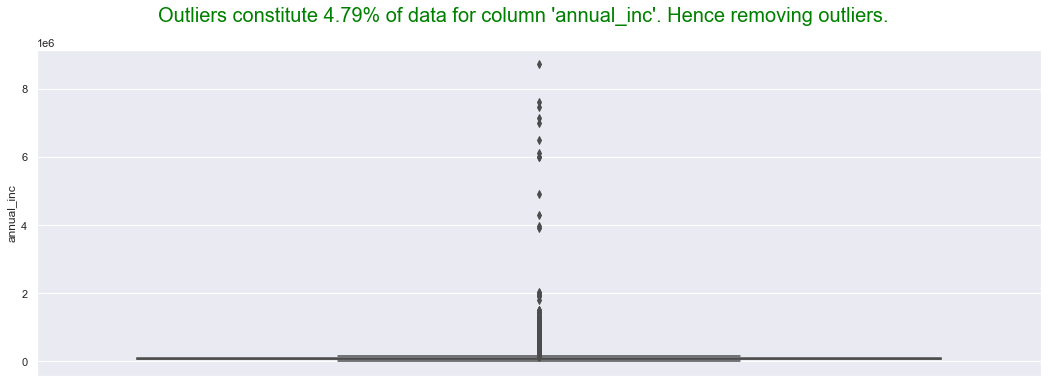

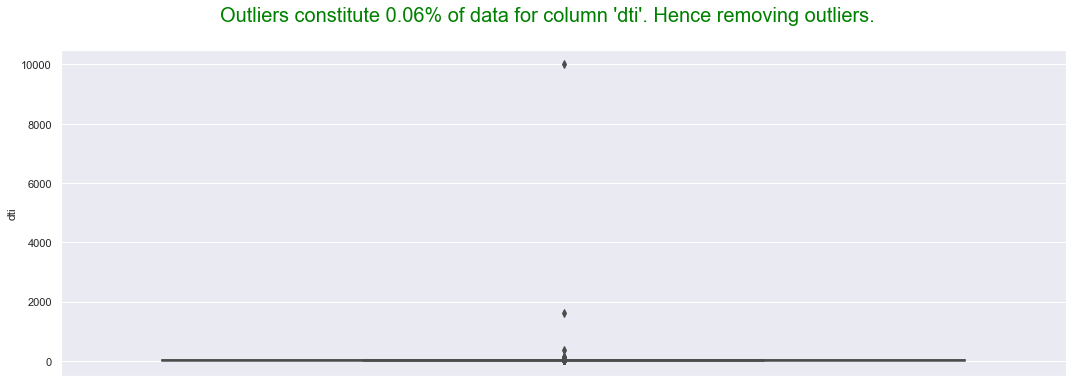

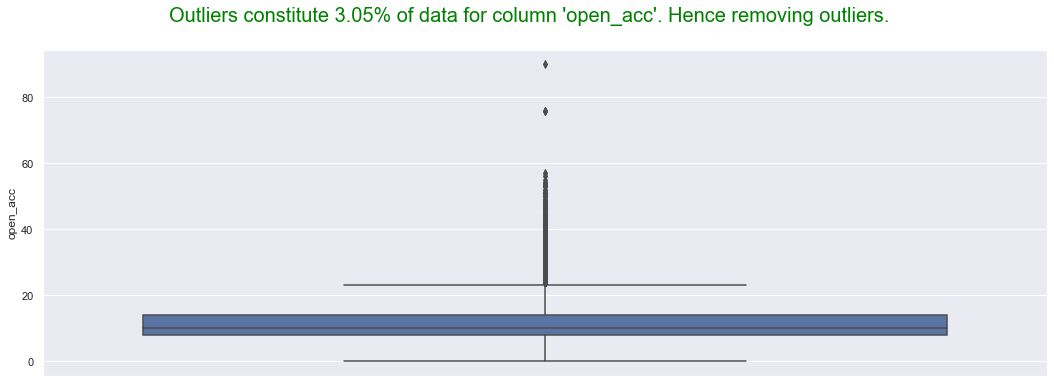

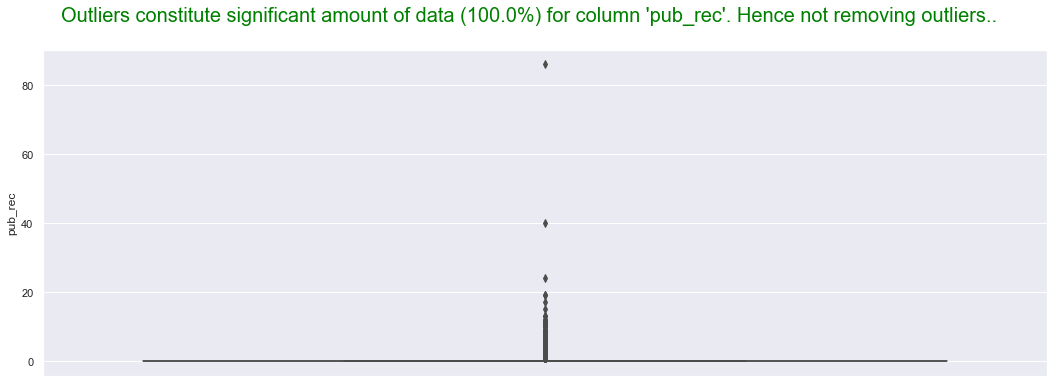

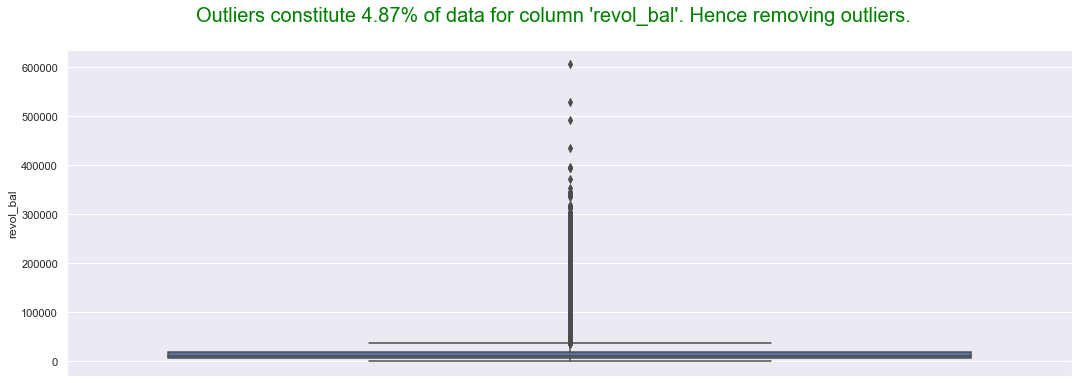

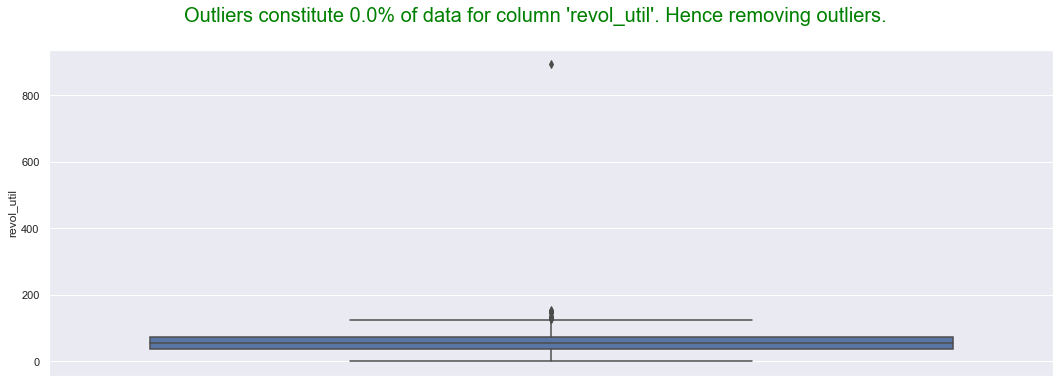

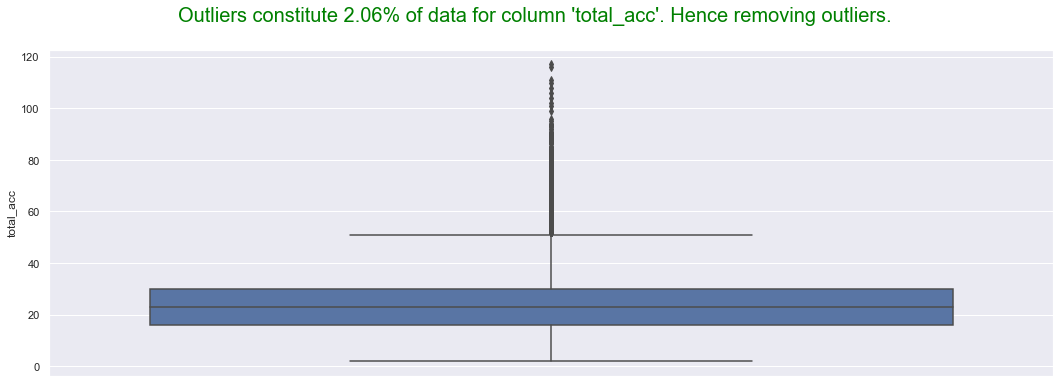

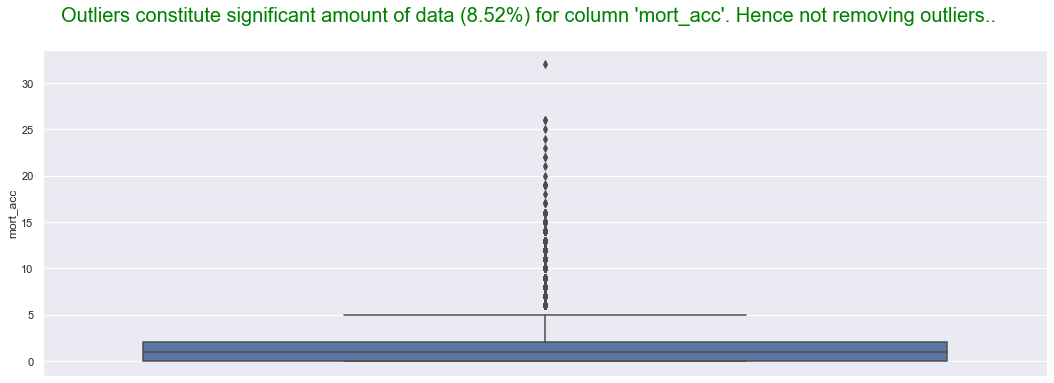

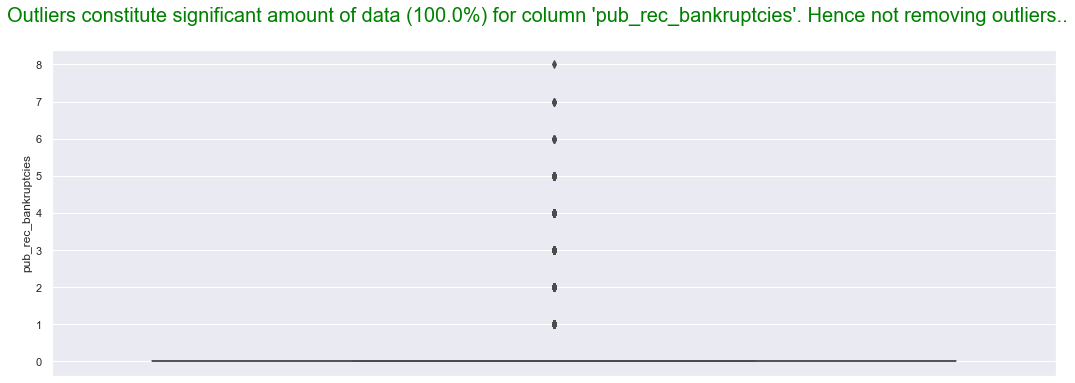

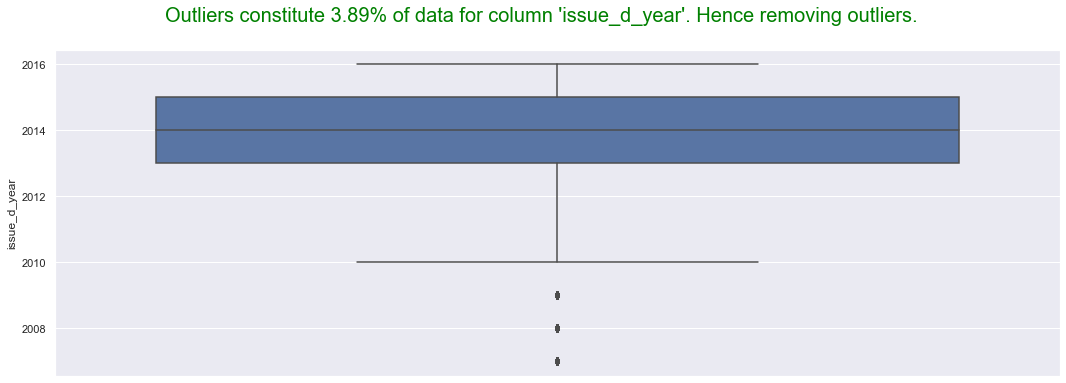

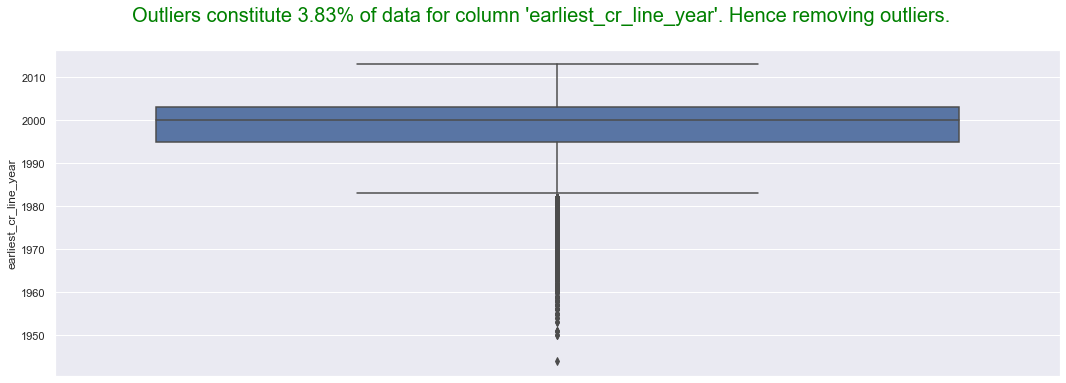

In [160]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column, thresh=5)

***
***
## **5. Univariate Analysis (Categorical Data).**

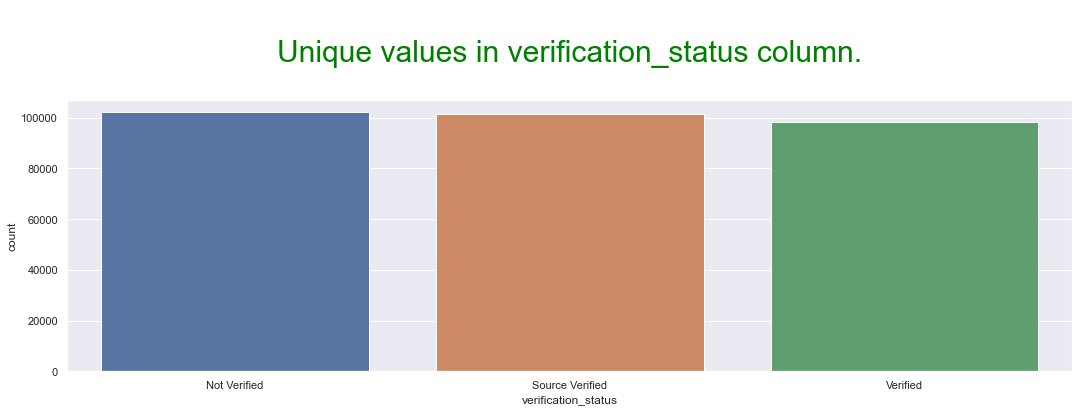

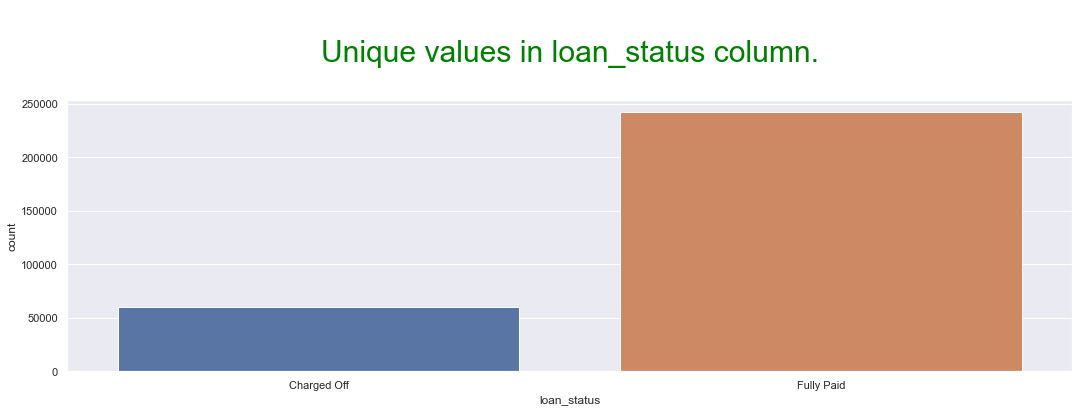

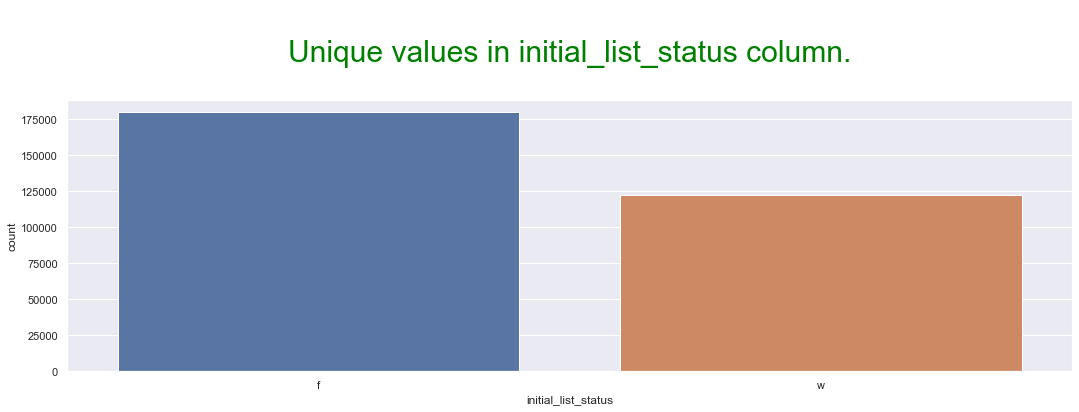

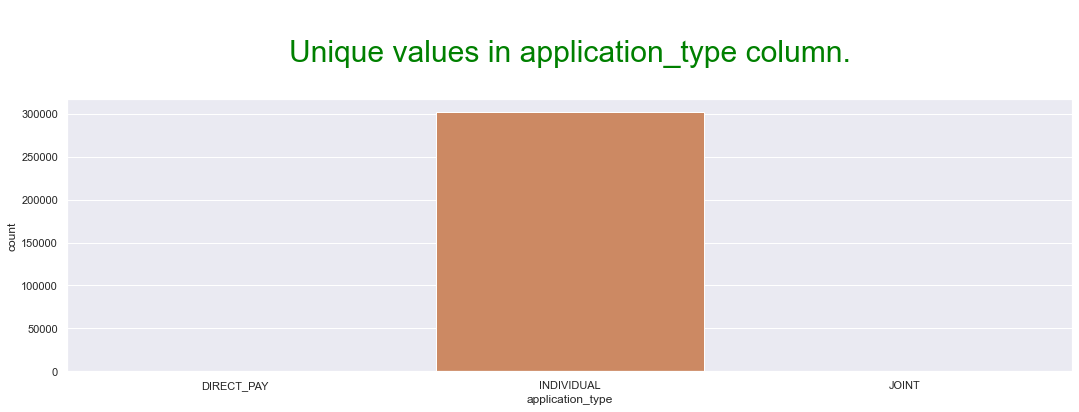

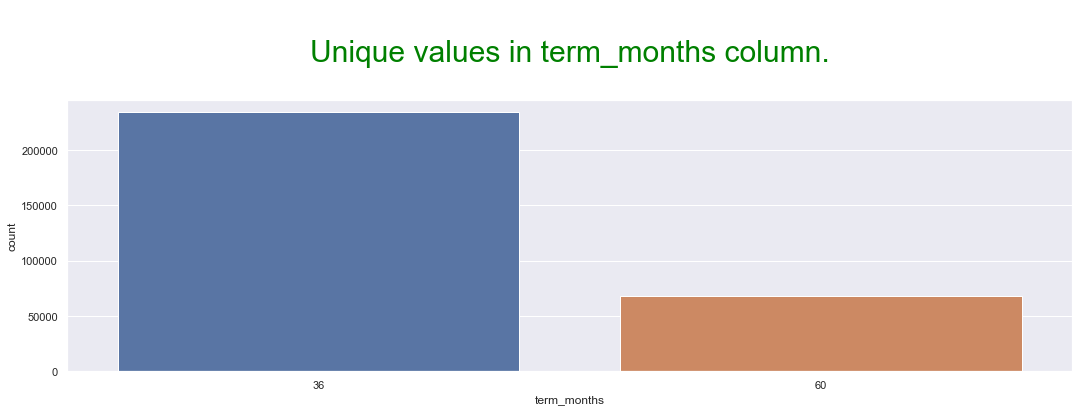

In [161]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,5))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **6. Univariate Analysis (Discrete Data).**

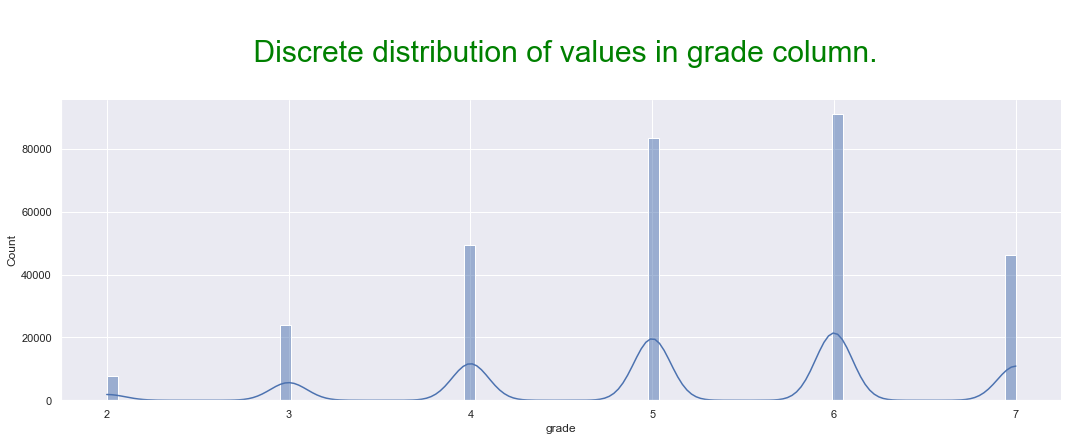

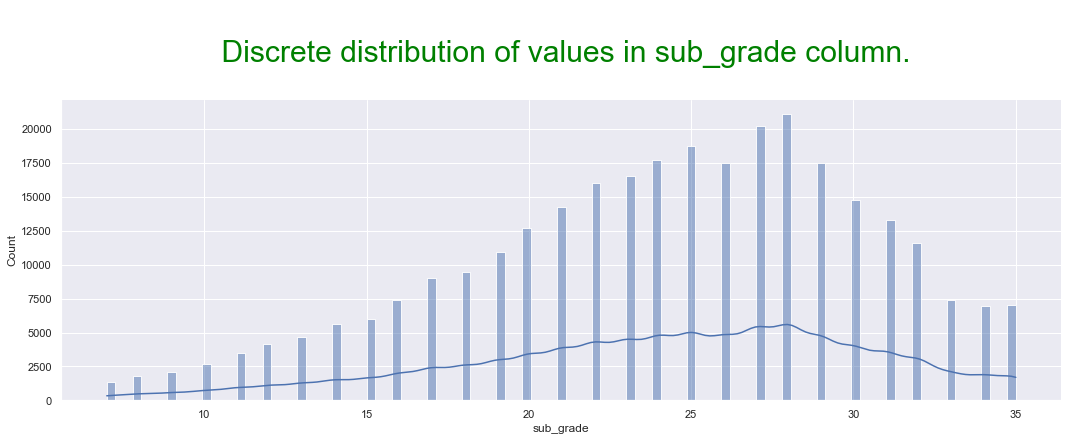

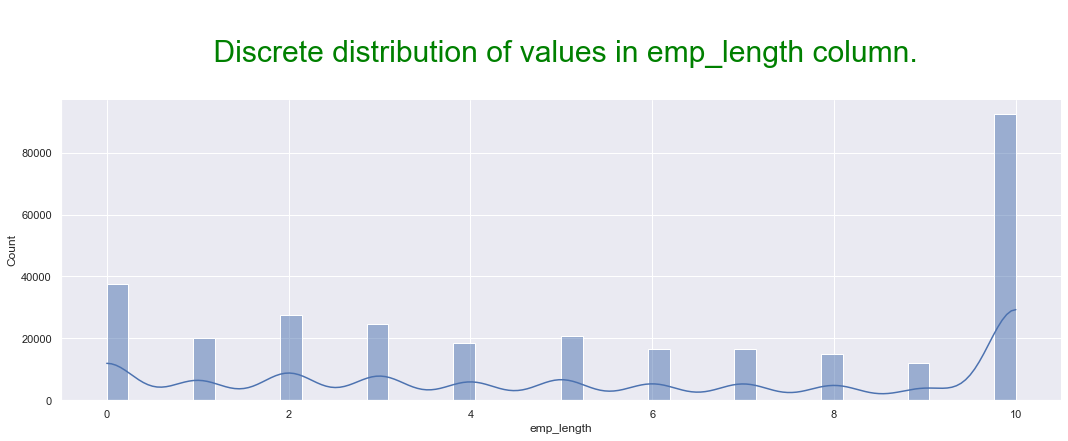

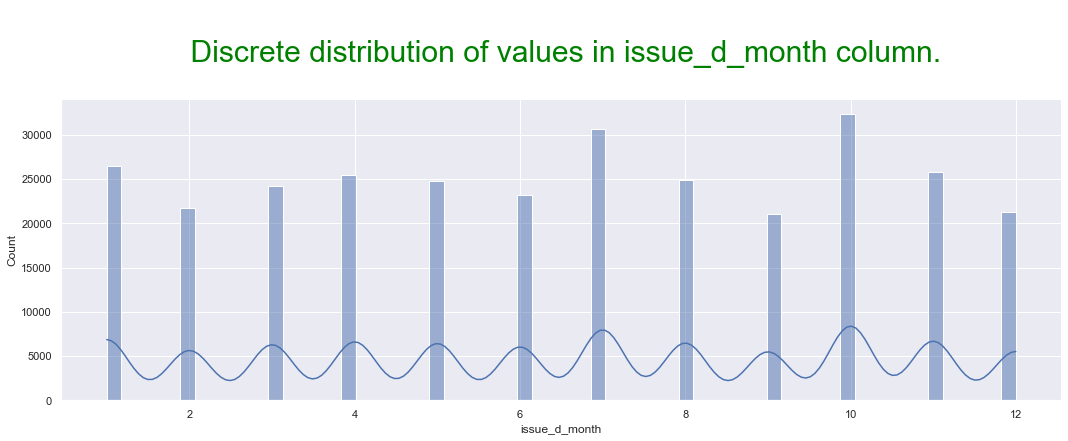

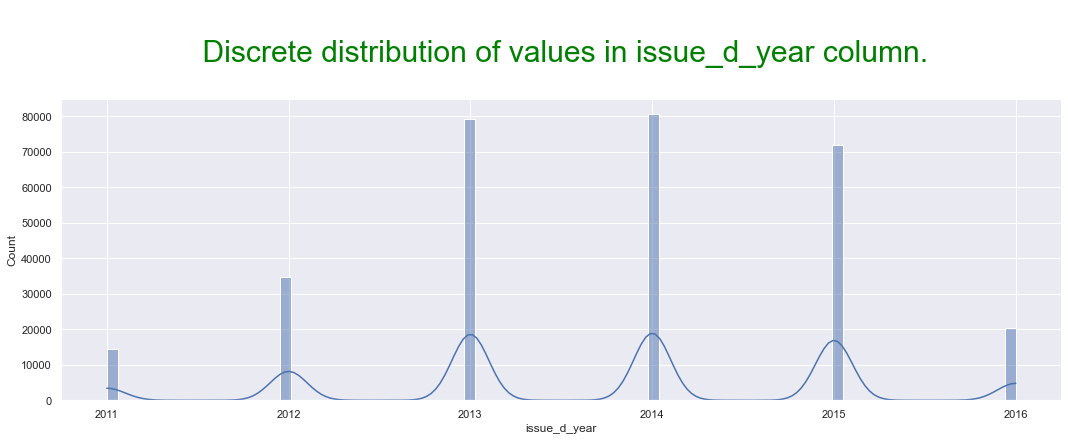

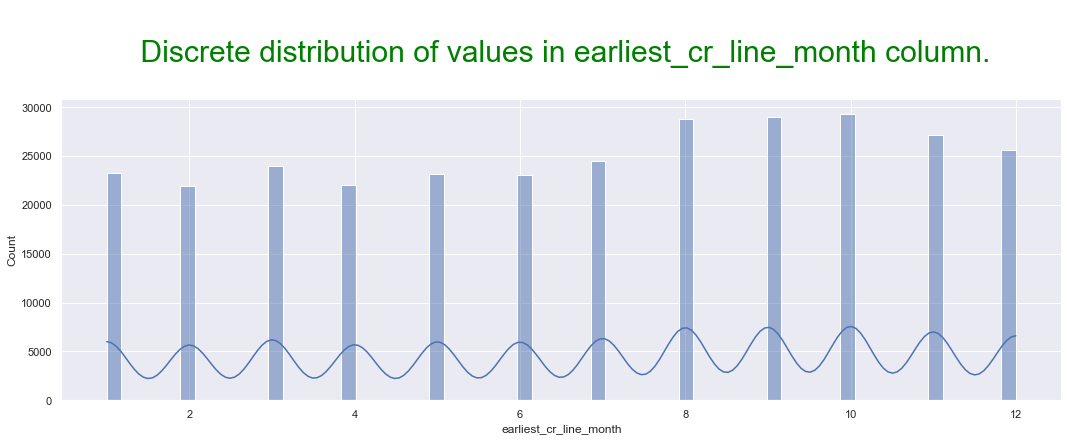

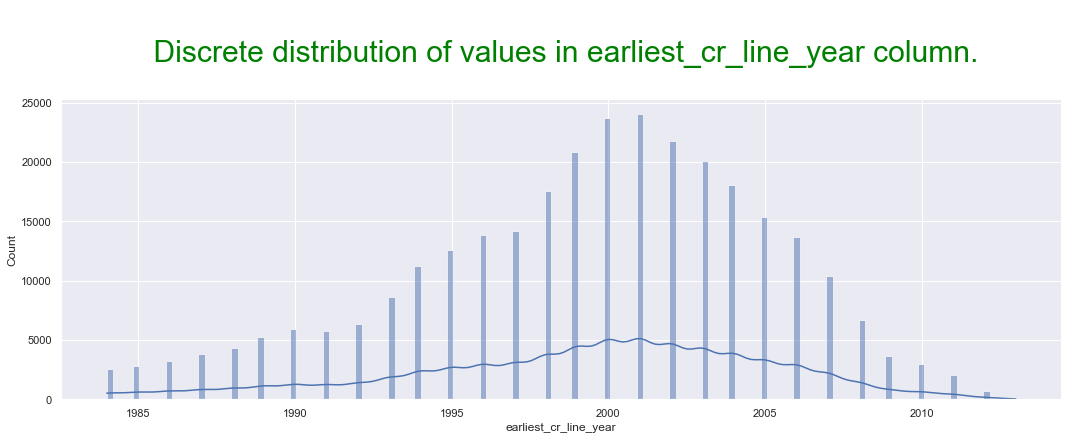

In [162]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **7. Univariate Analysis (Continuous Data).**

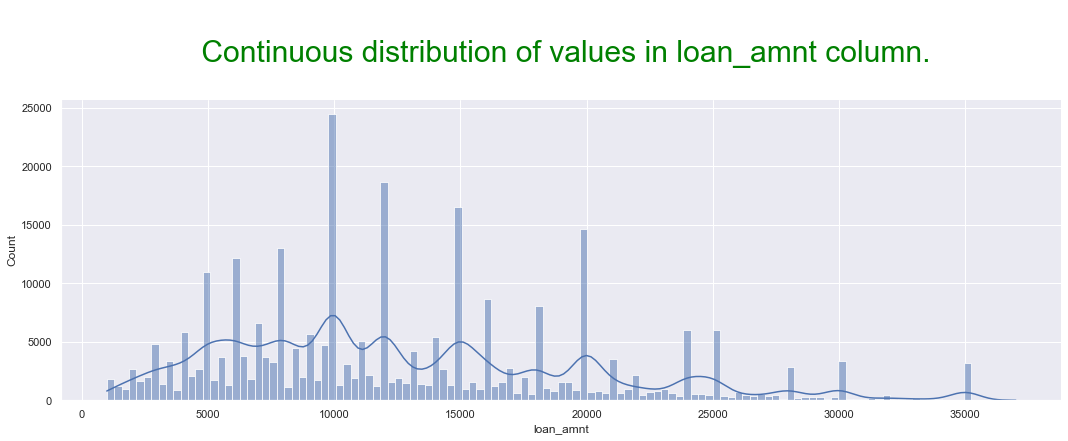

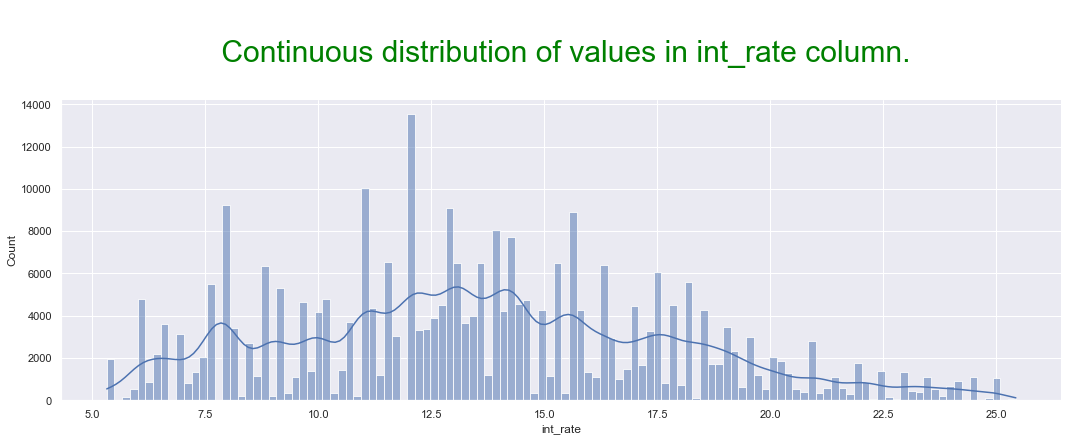

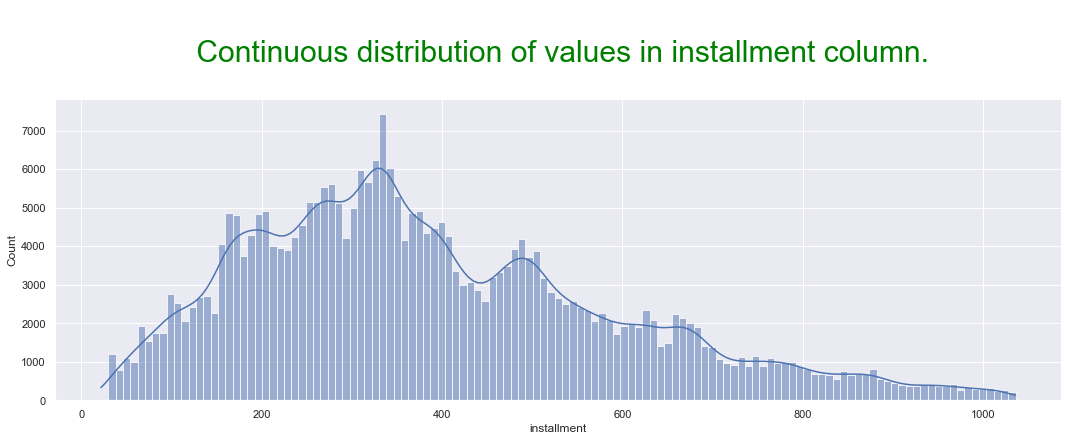

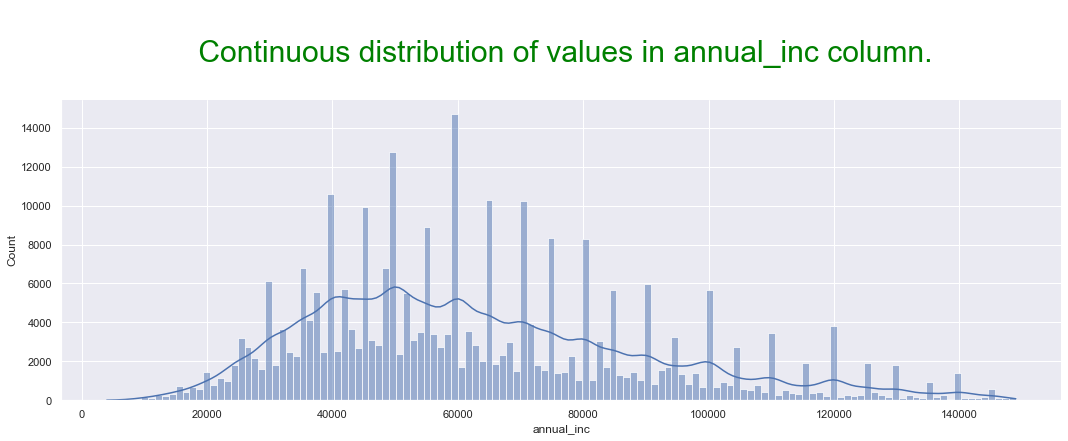

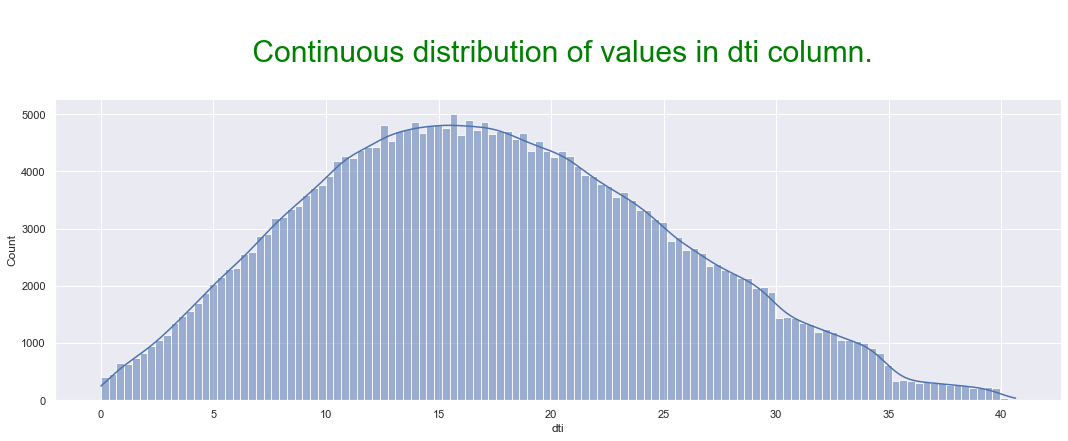

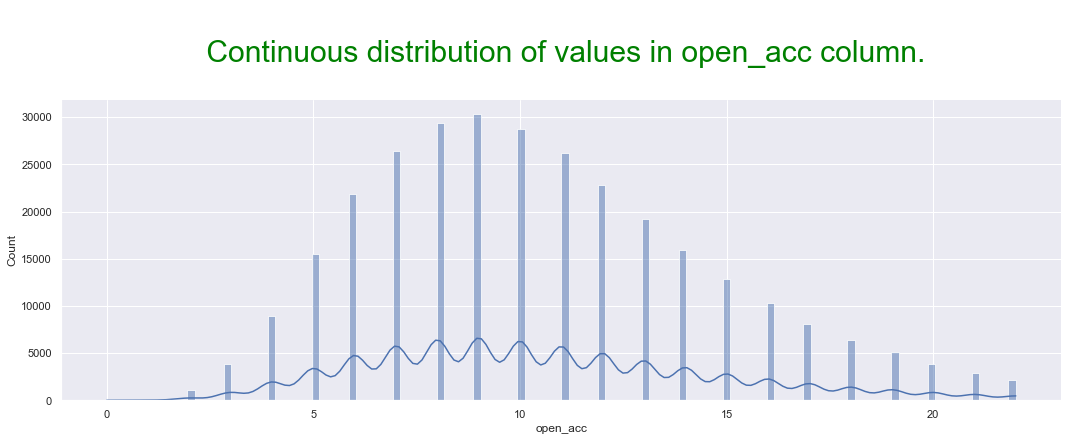

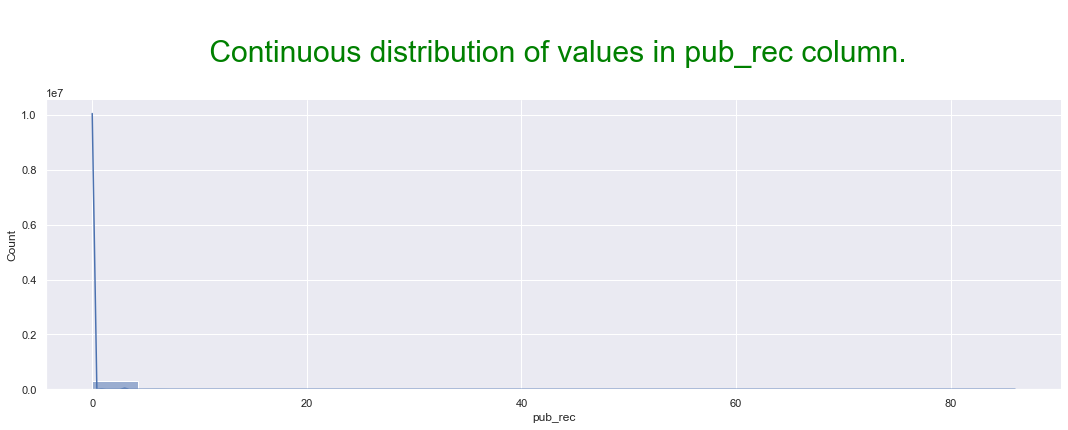

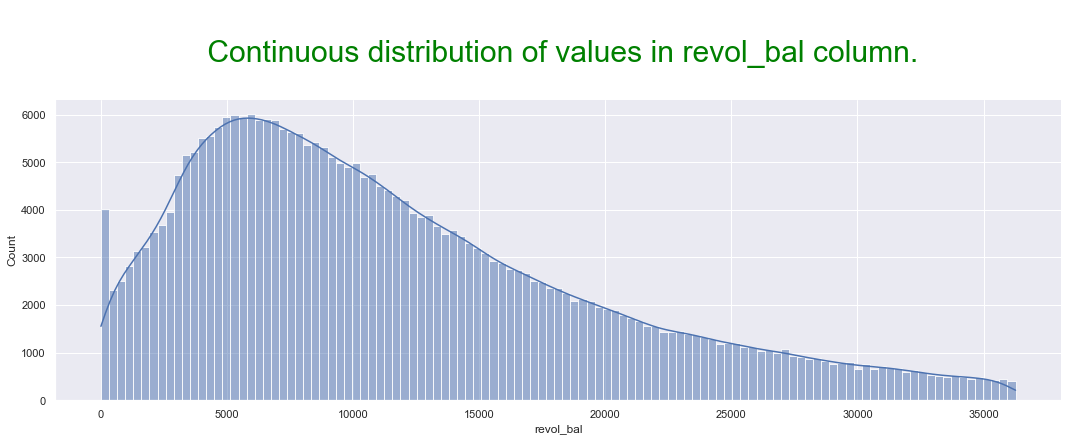

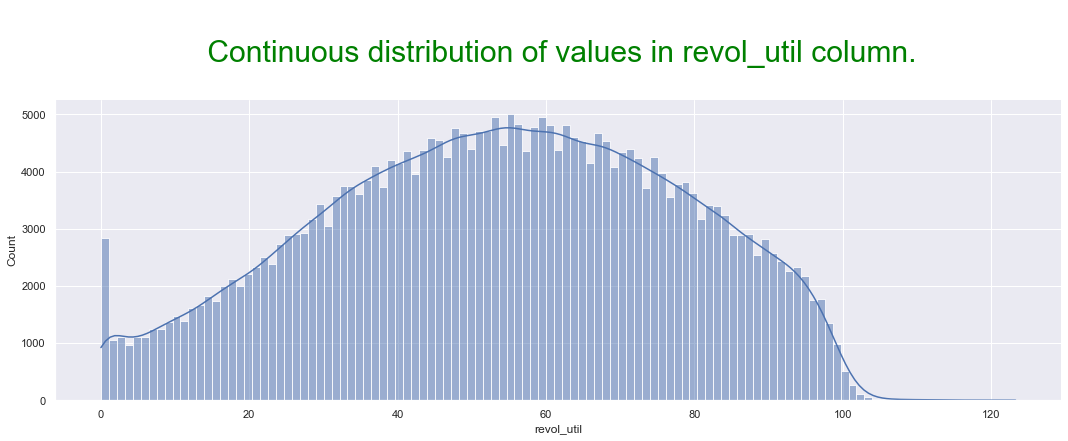

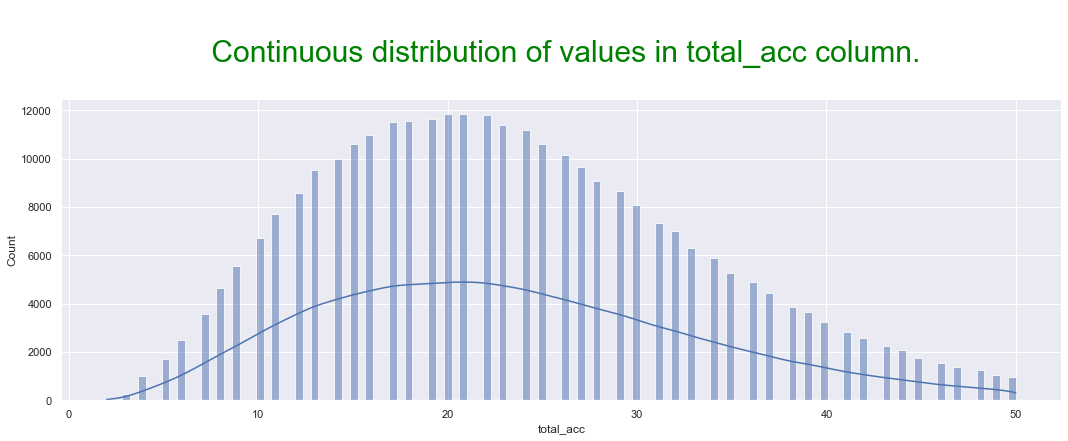

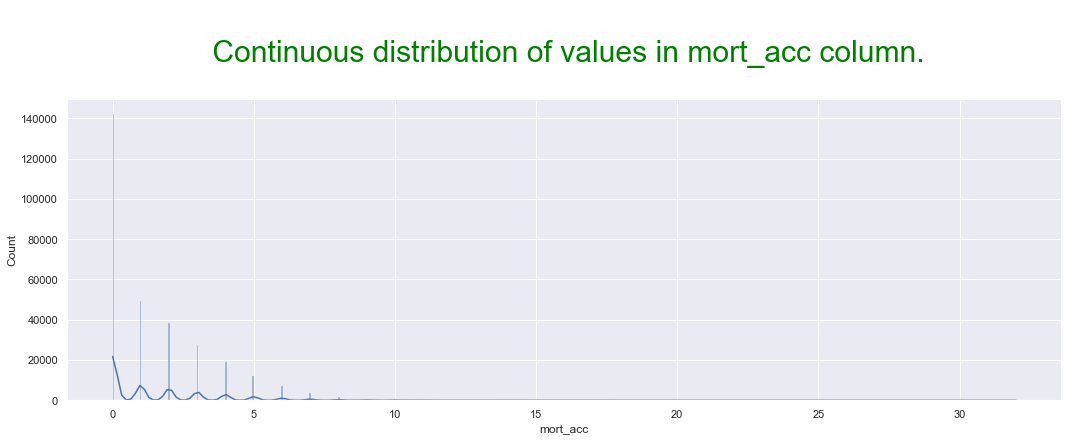

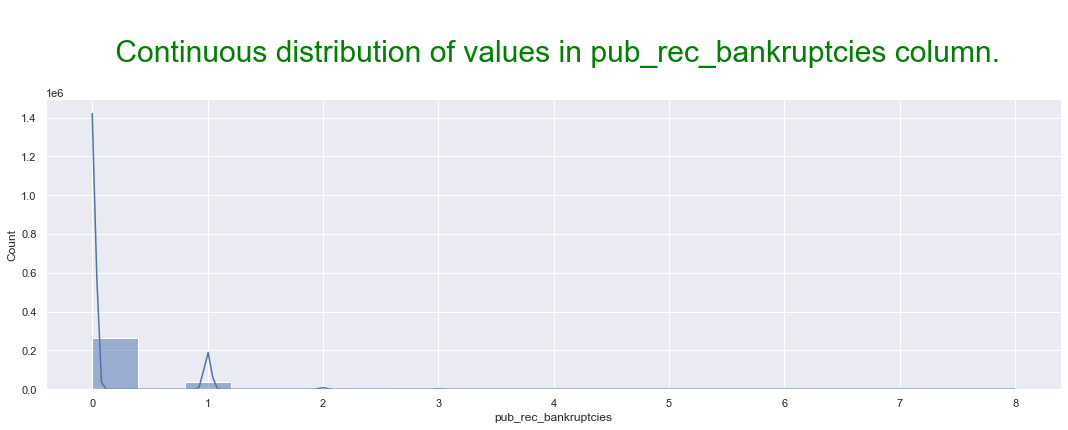

In [163]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **8. Bivariate Analysis.**

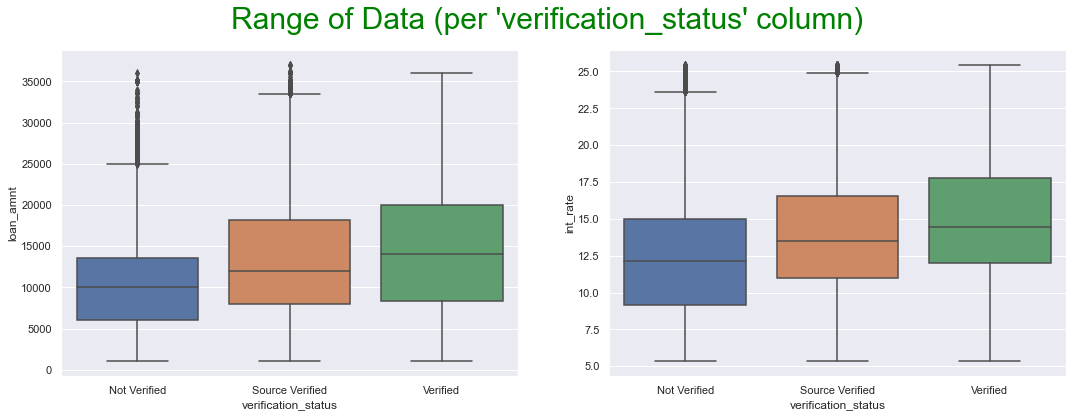

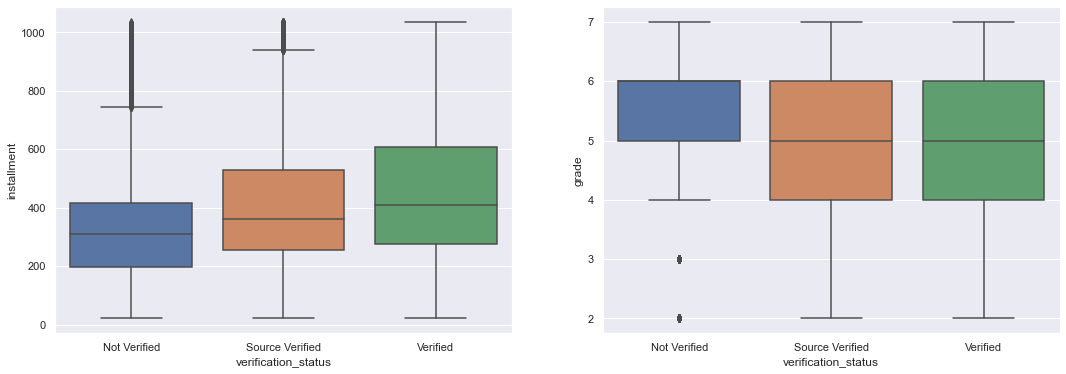

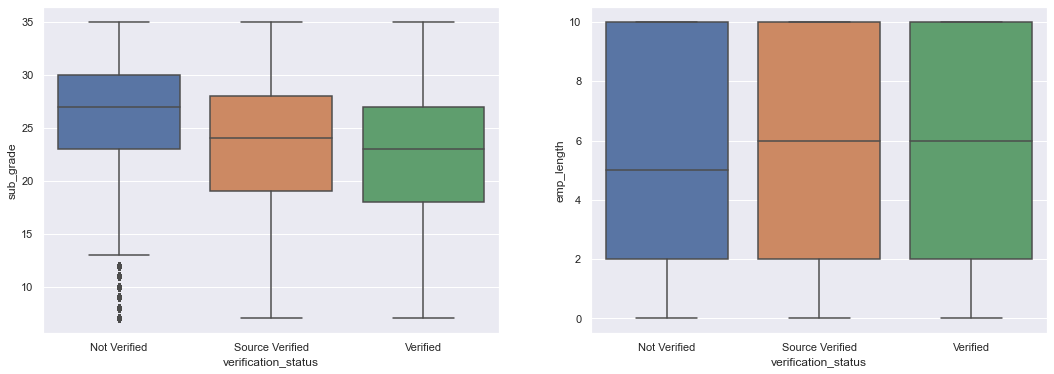

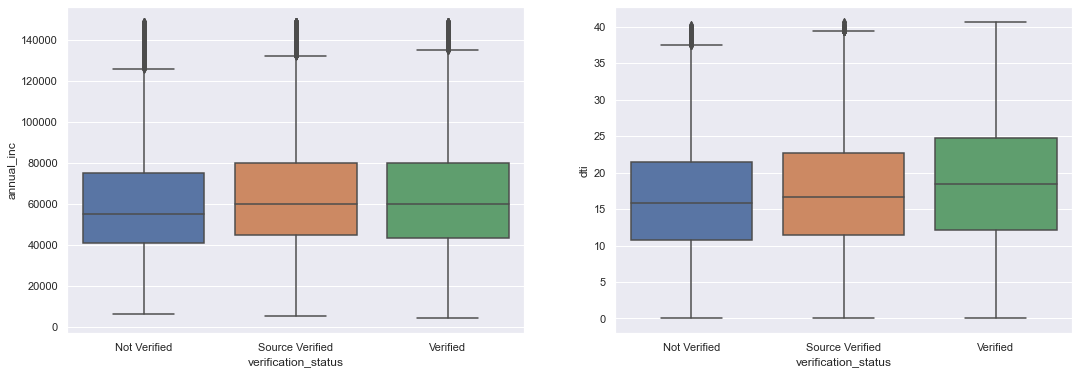

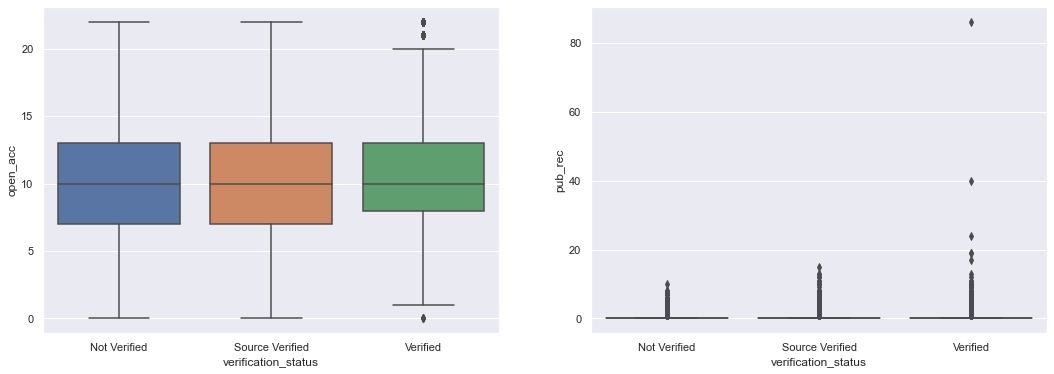

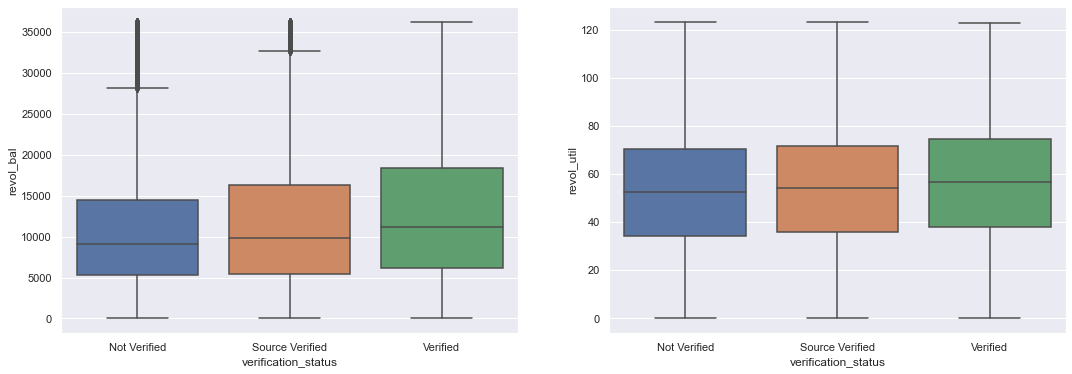

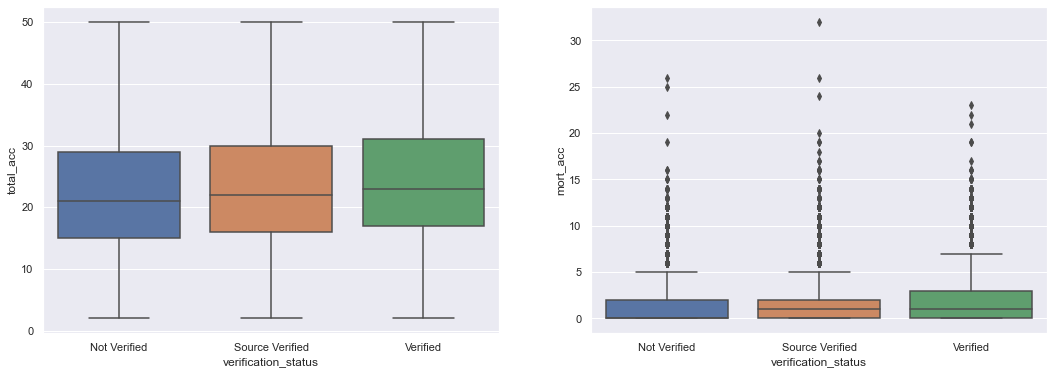

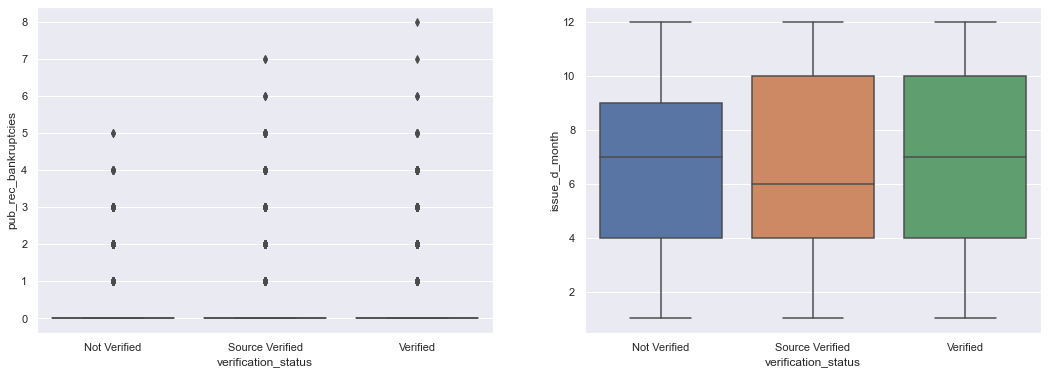

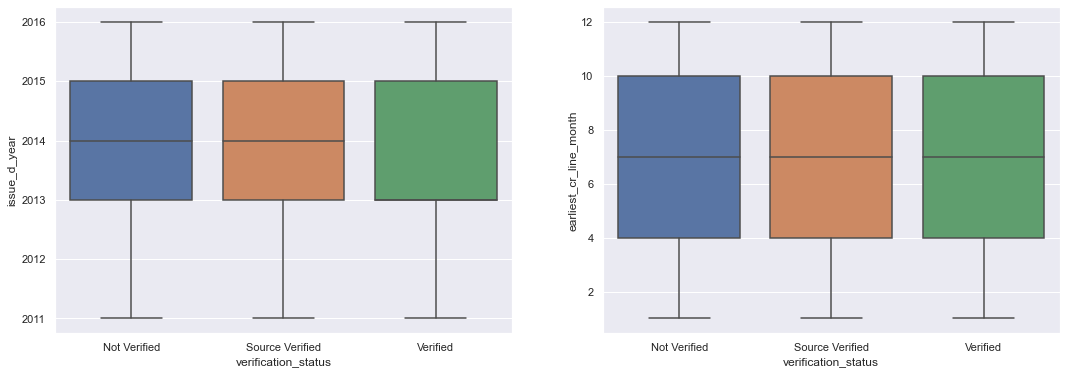

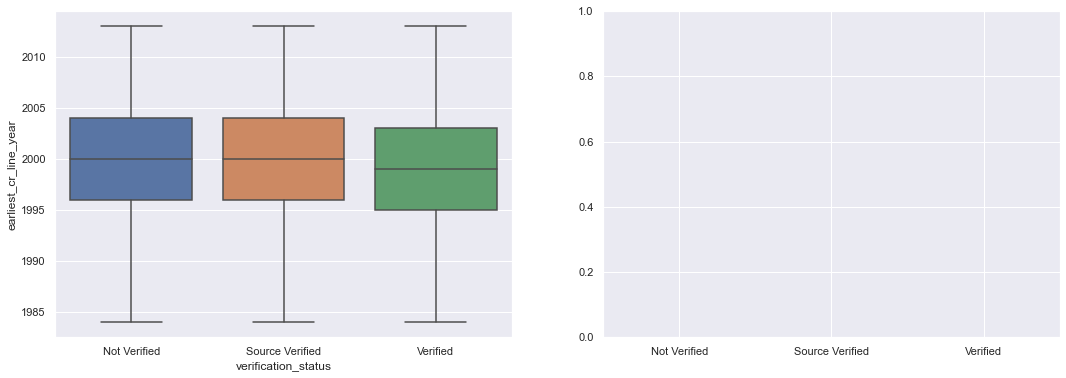

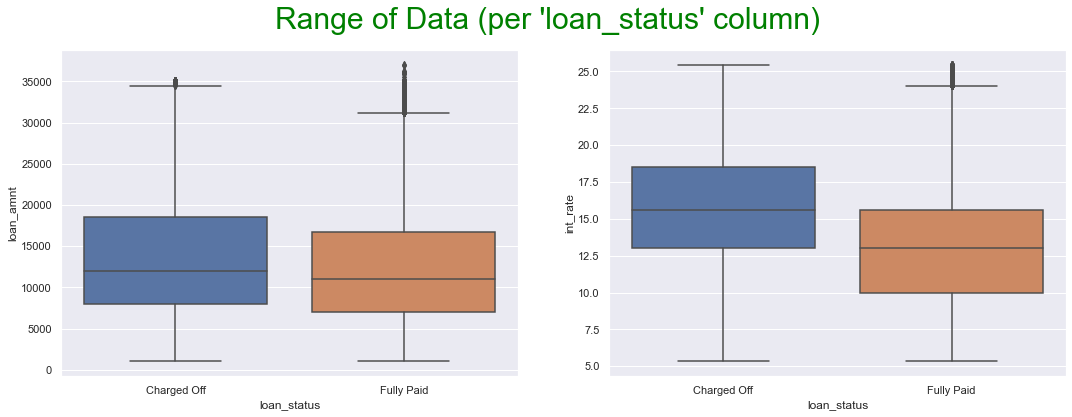

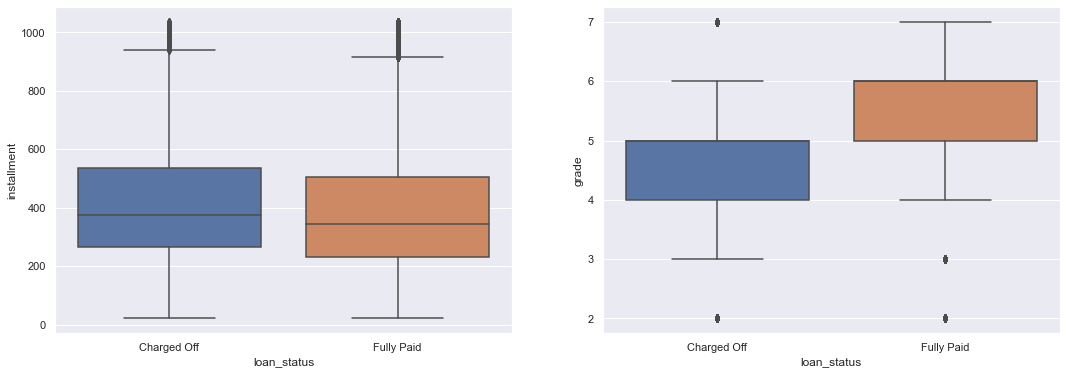

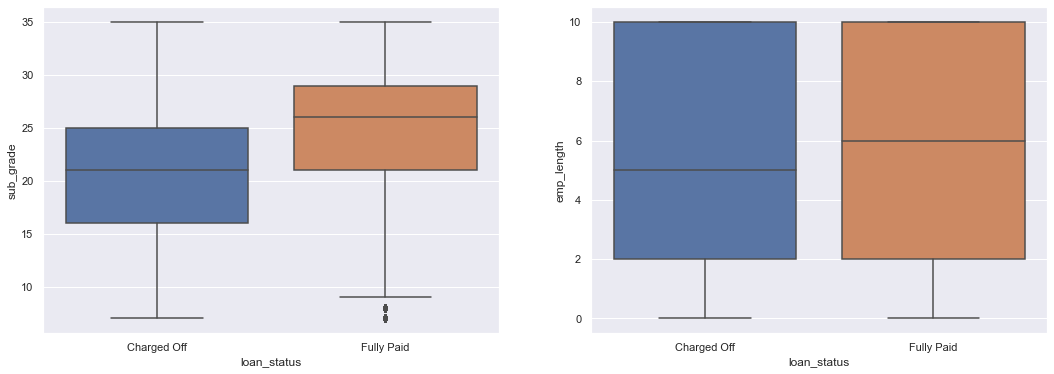

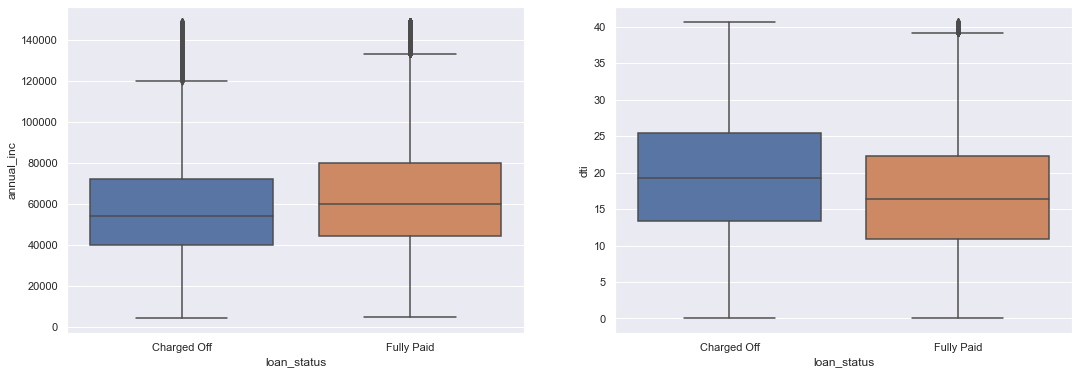

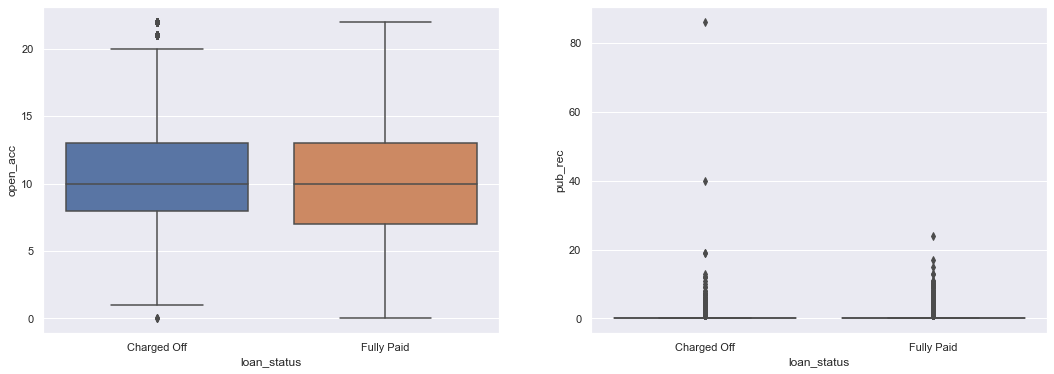

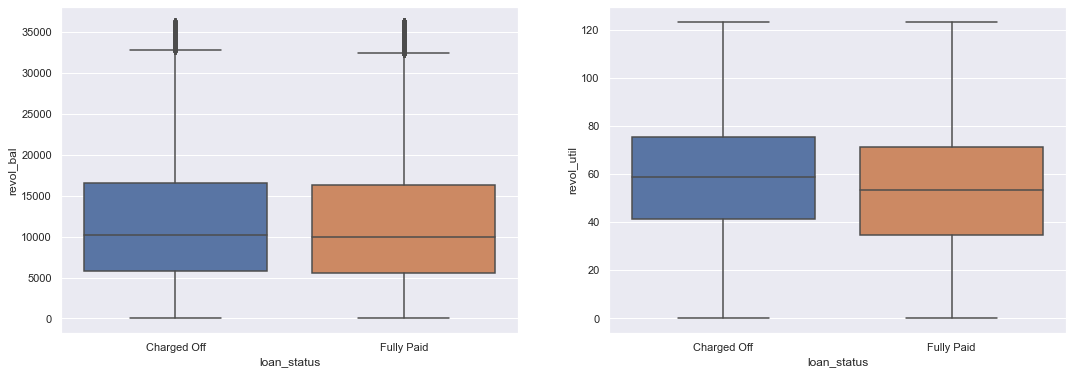

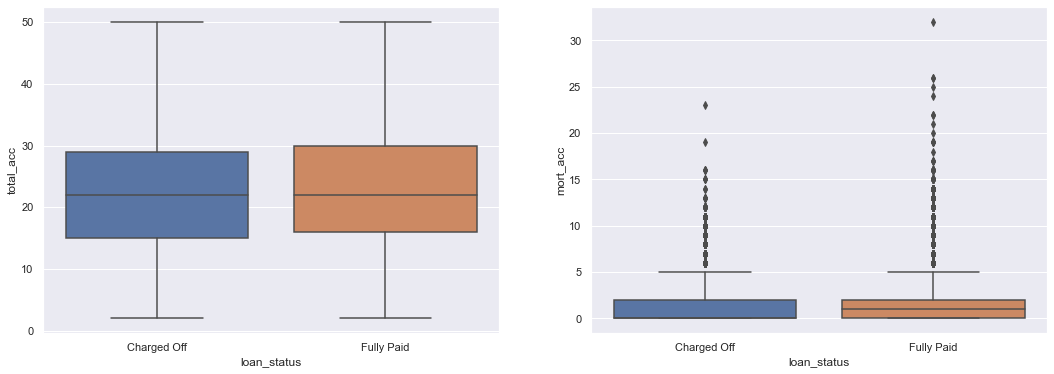

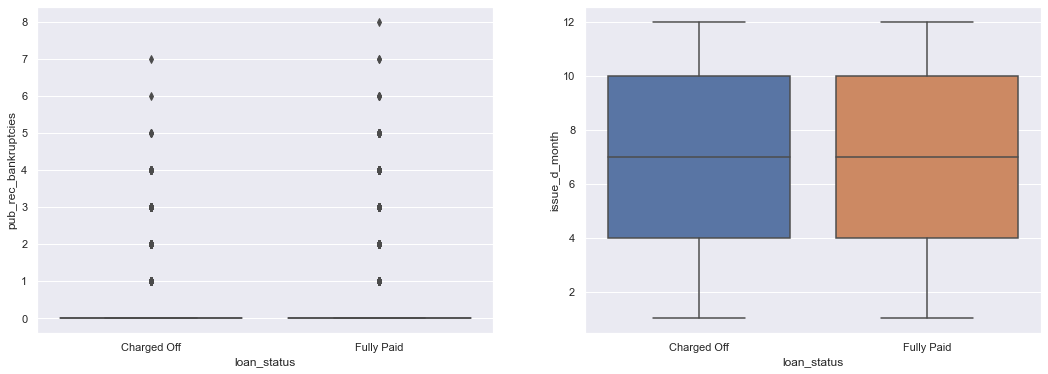

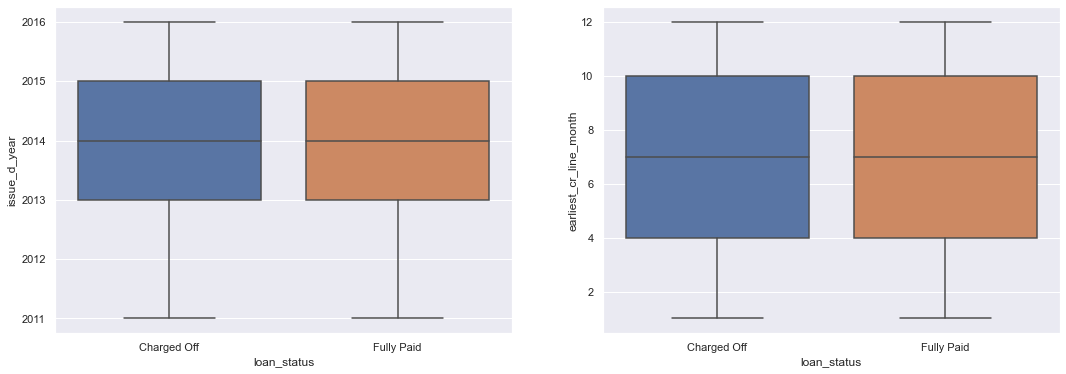

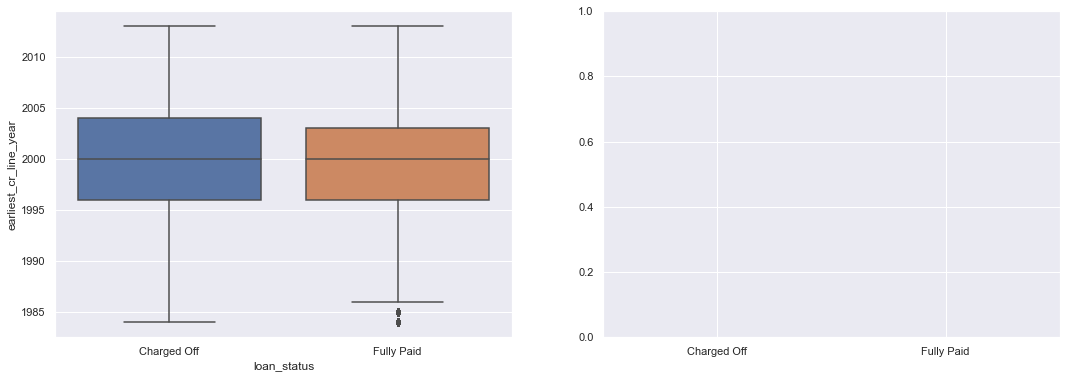

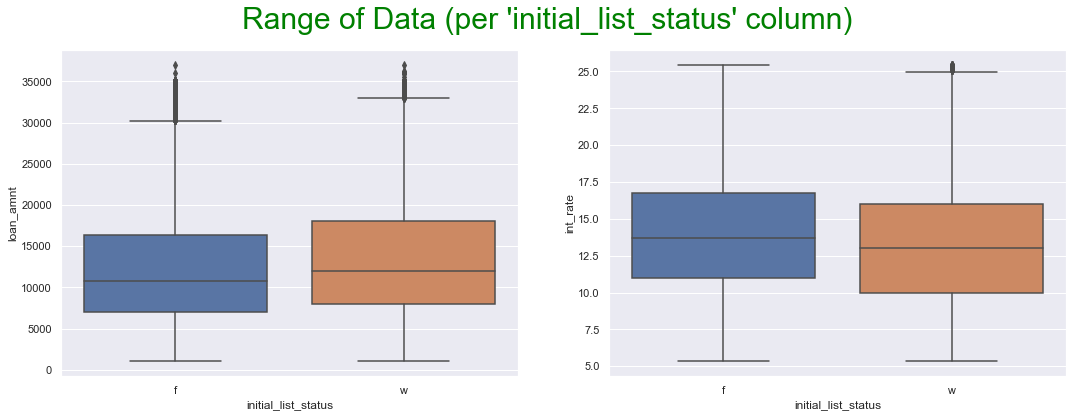

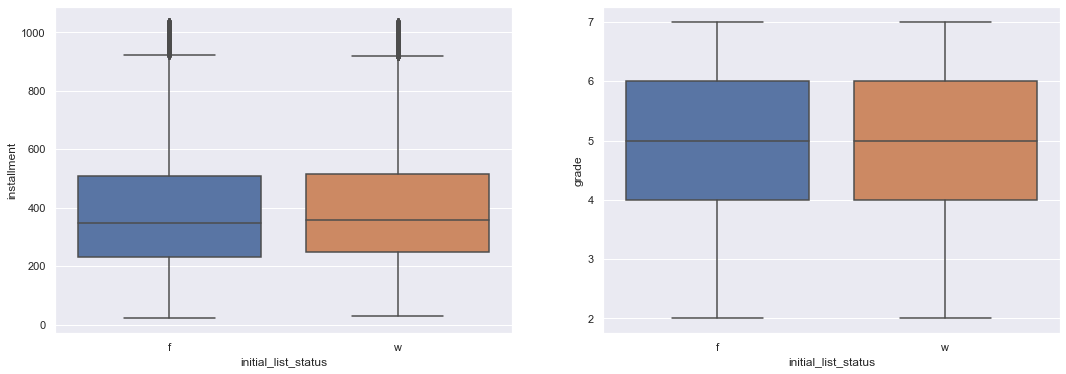

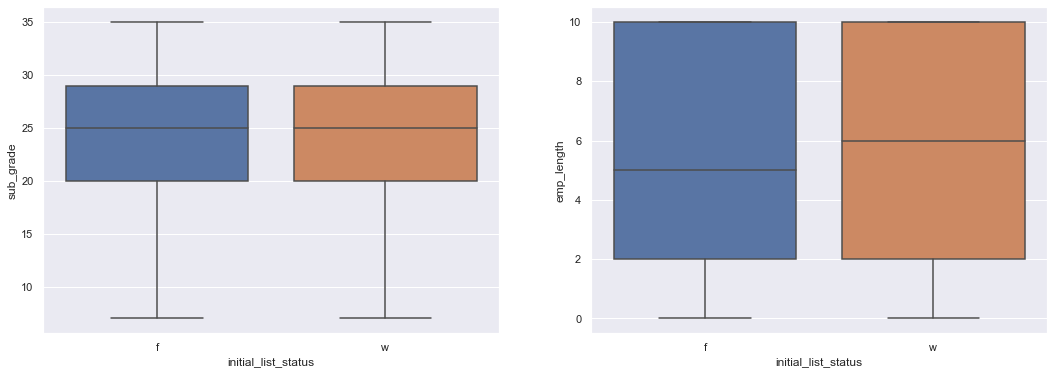

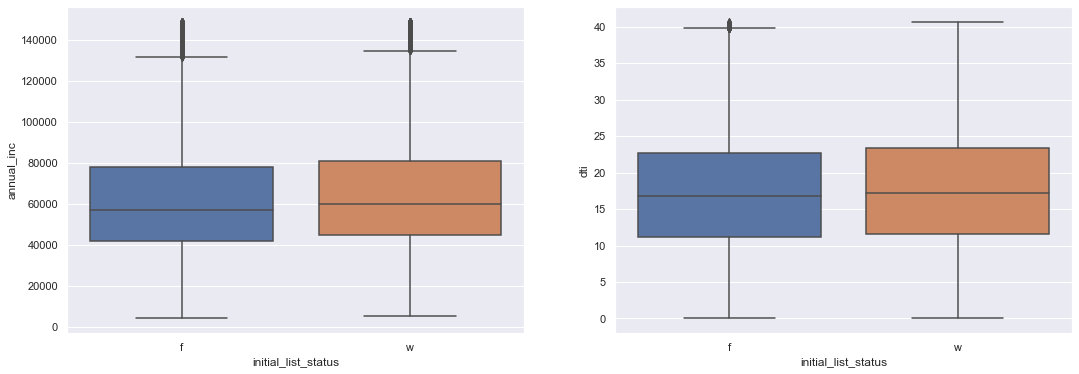

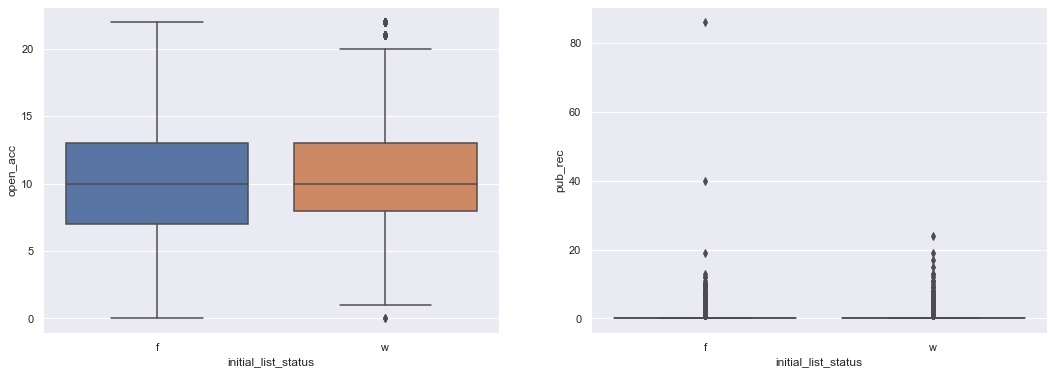

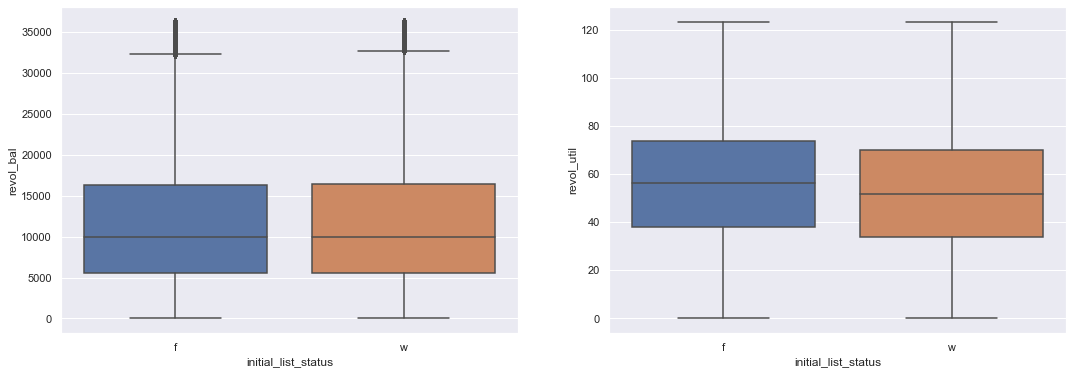

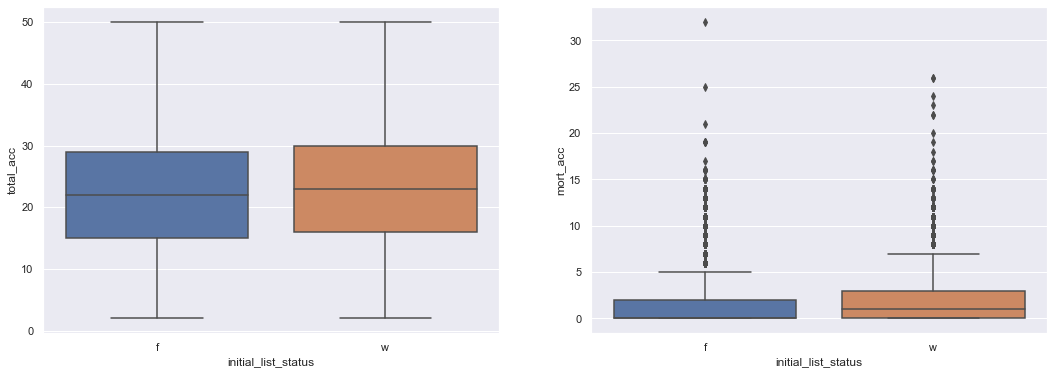

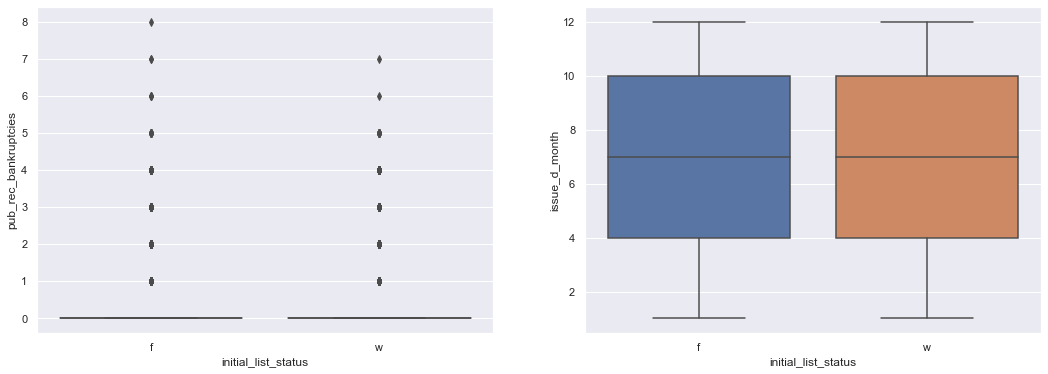

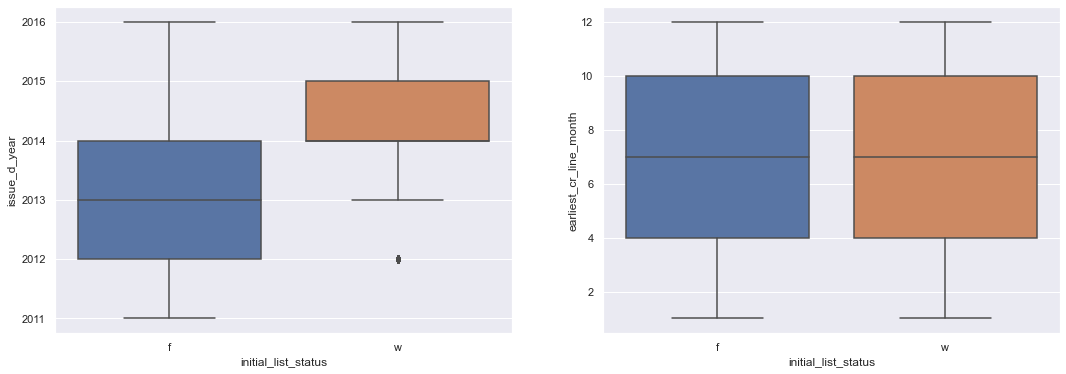

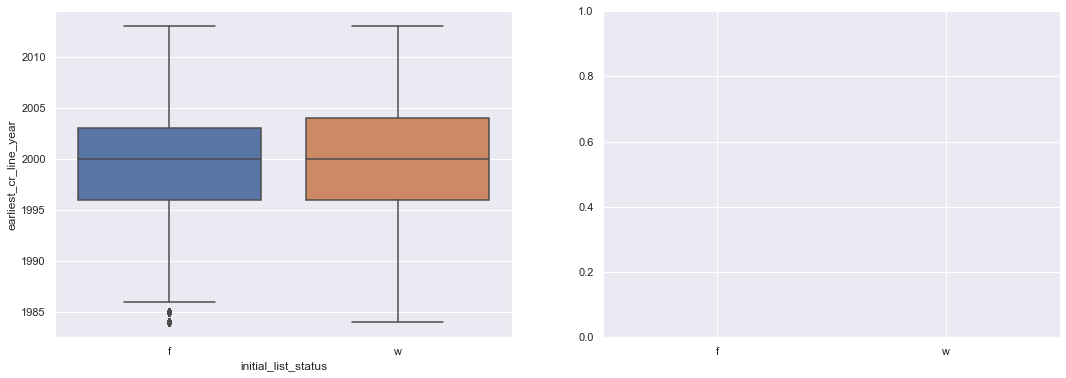

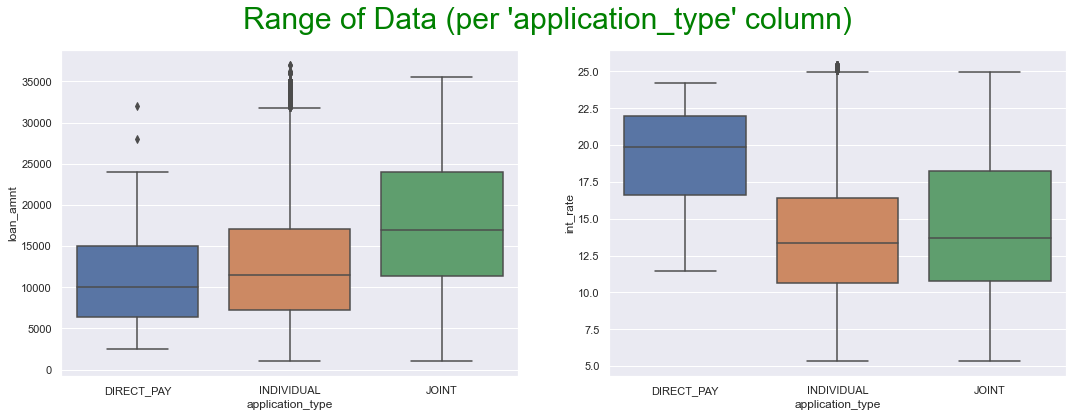

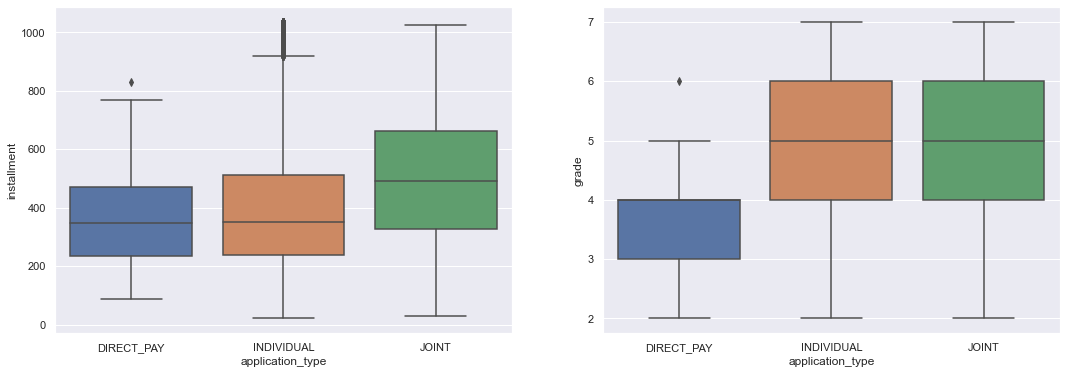

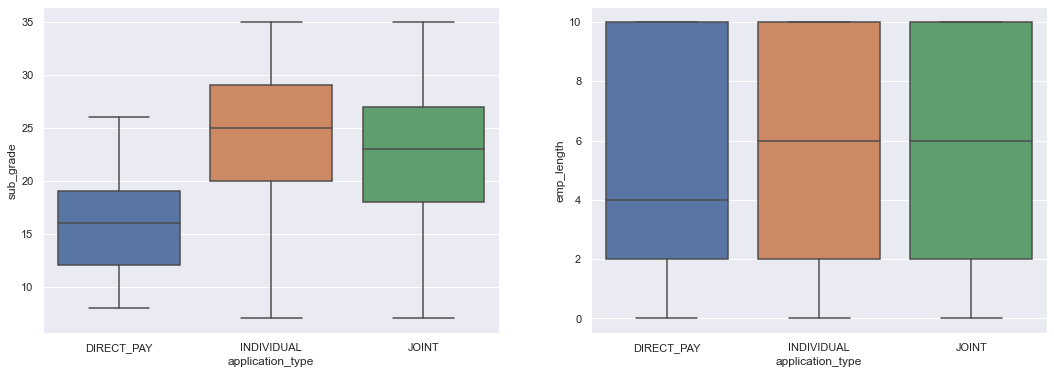

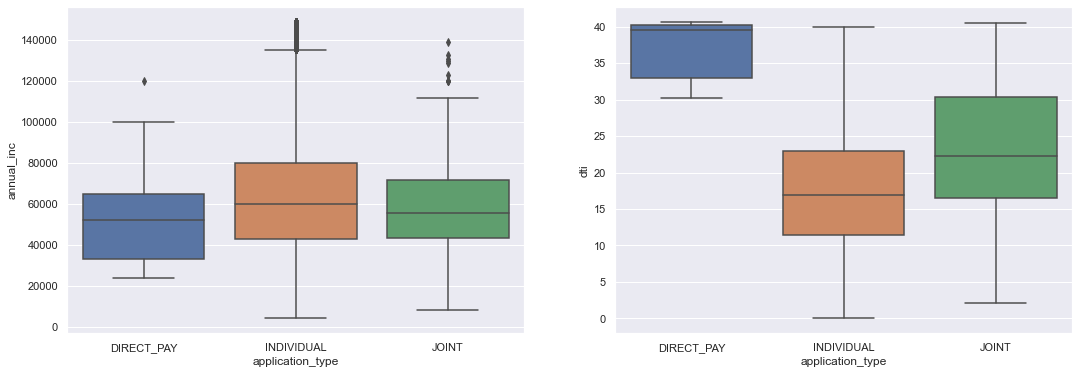

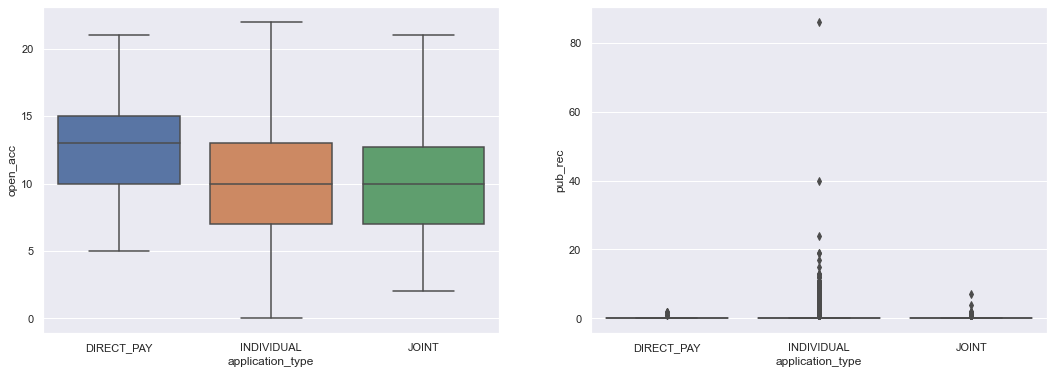

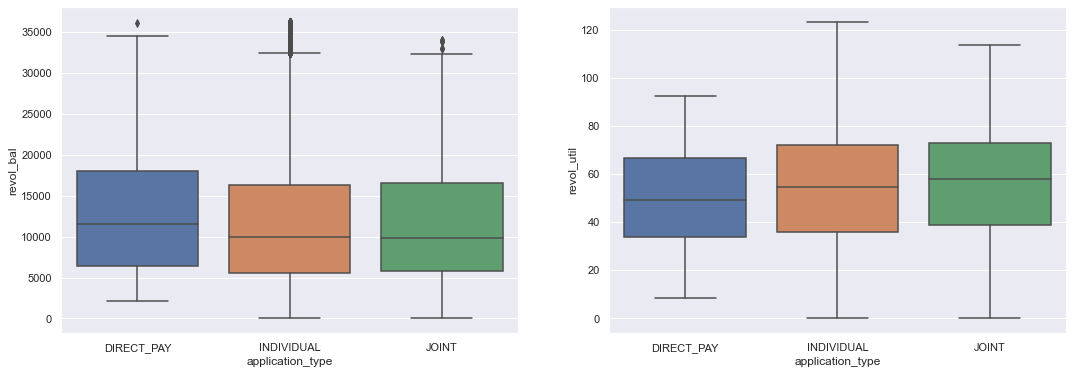

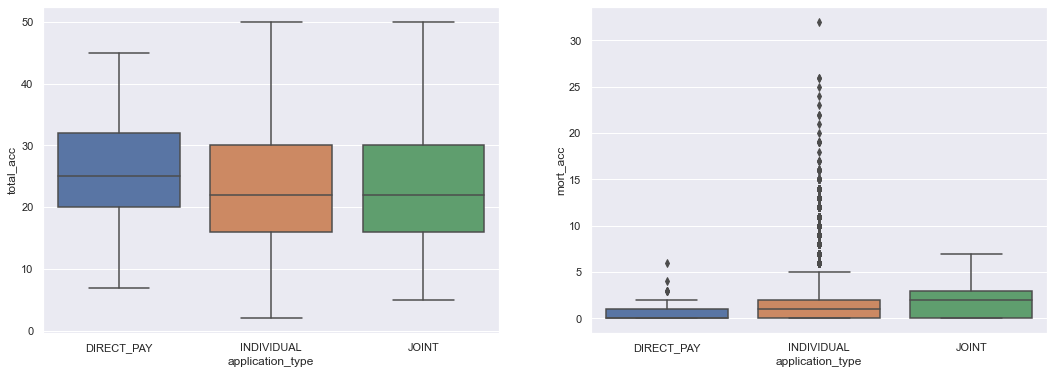

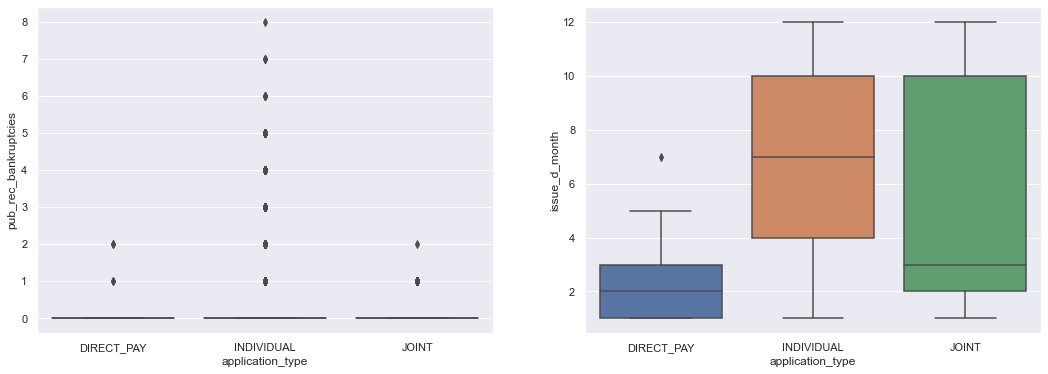

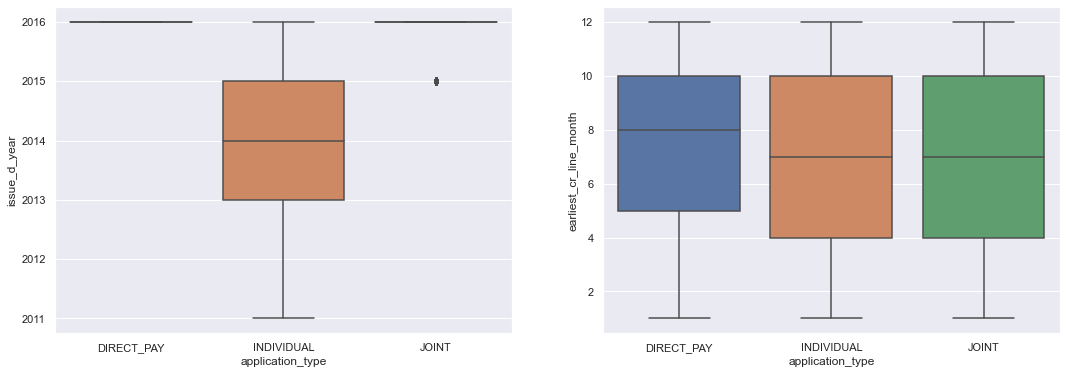

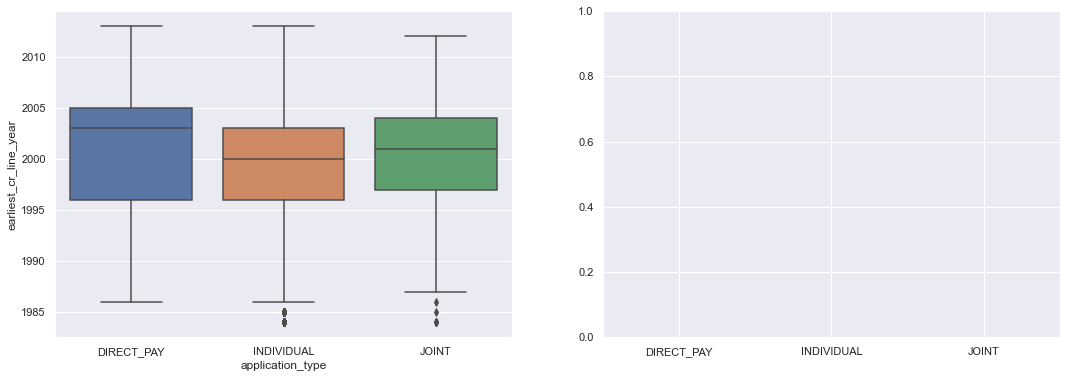

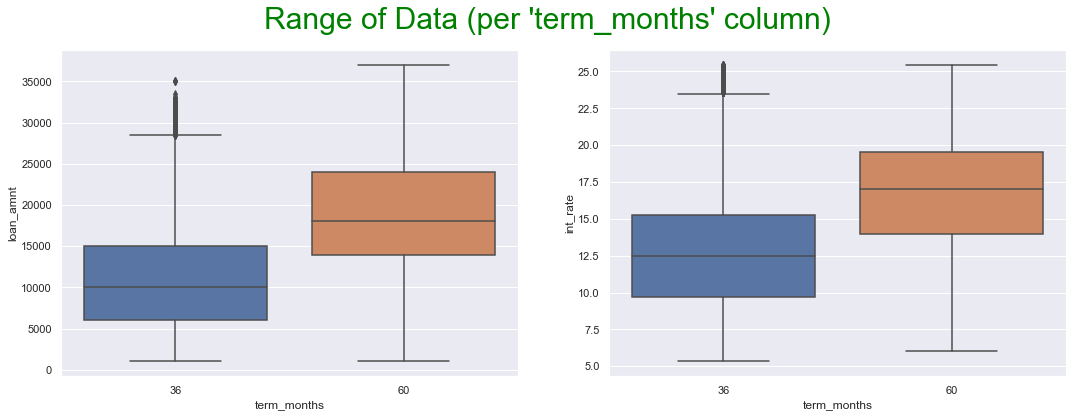

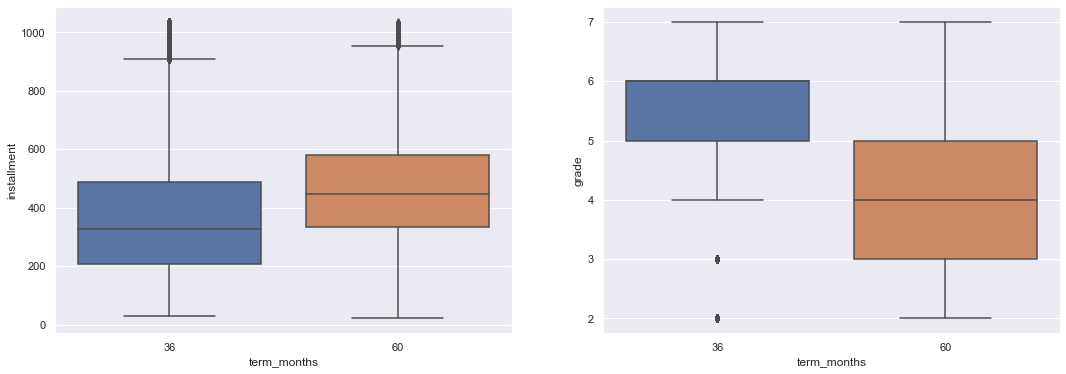

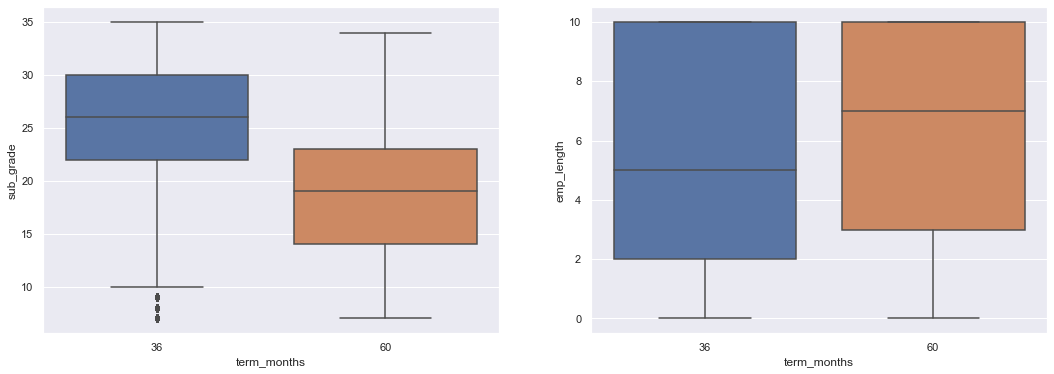

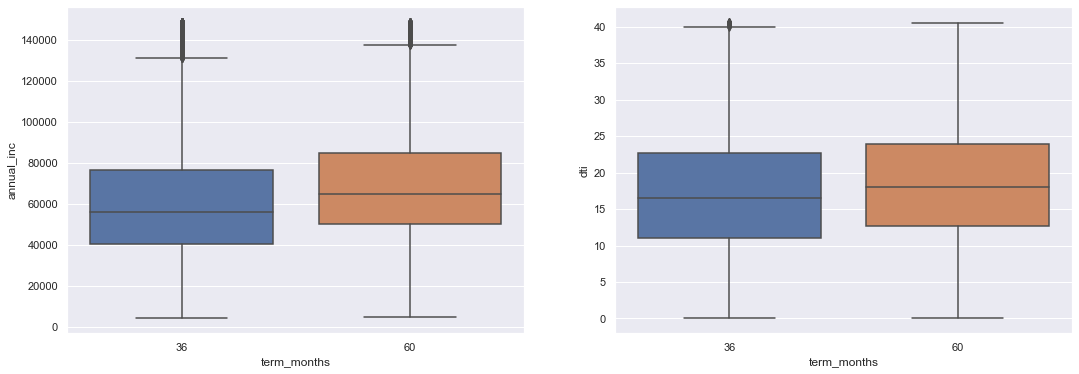

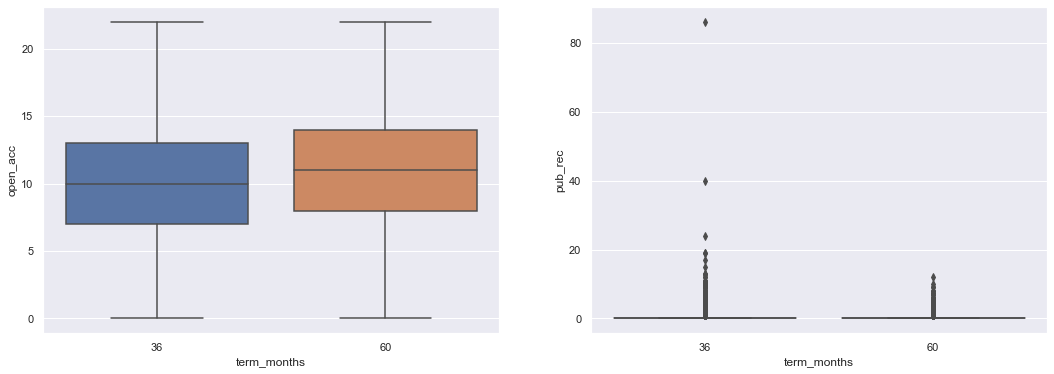

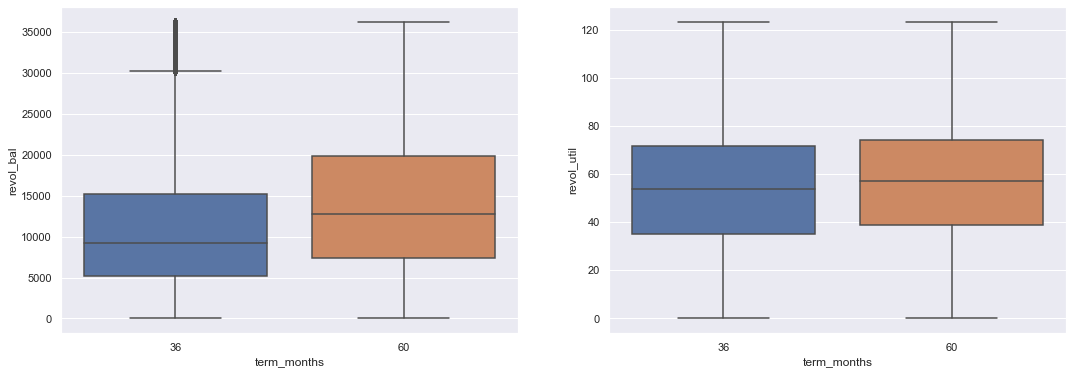

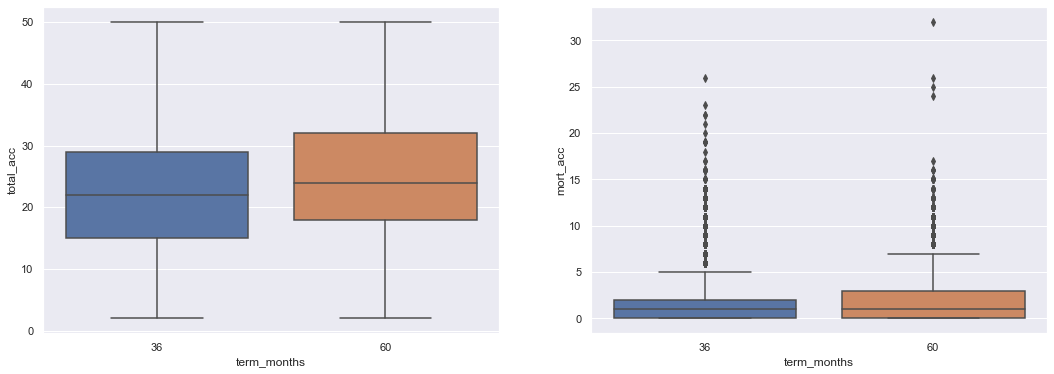

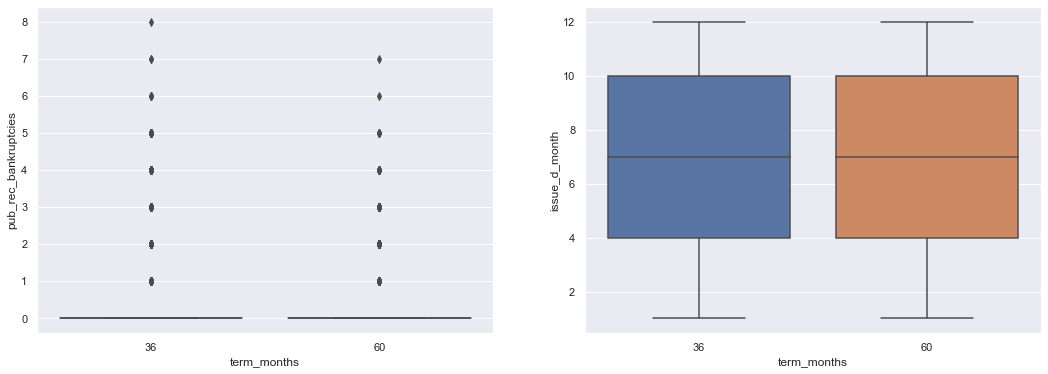

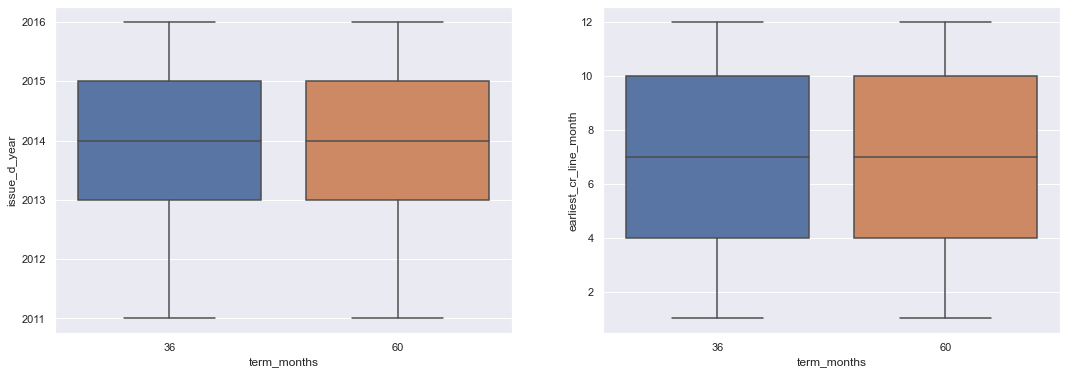

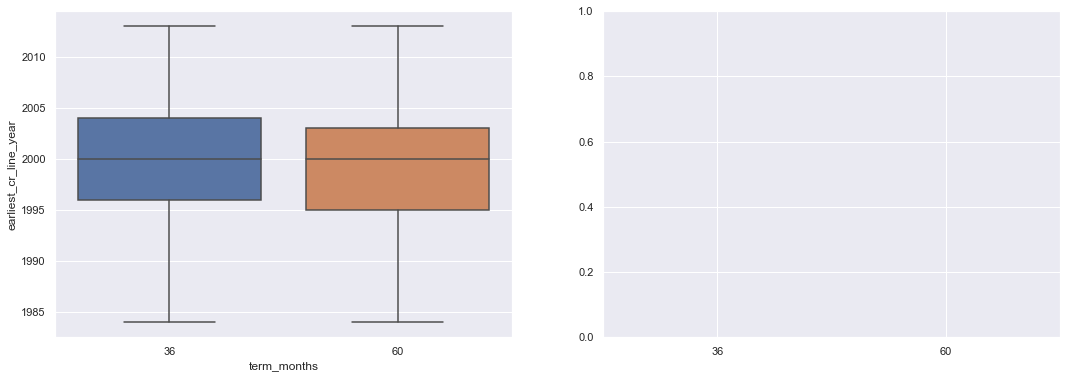

In [164]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show() 

***
***
## **9. Analysis of Correlation Between Data.**

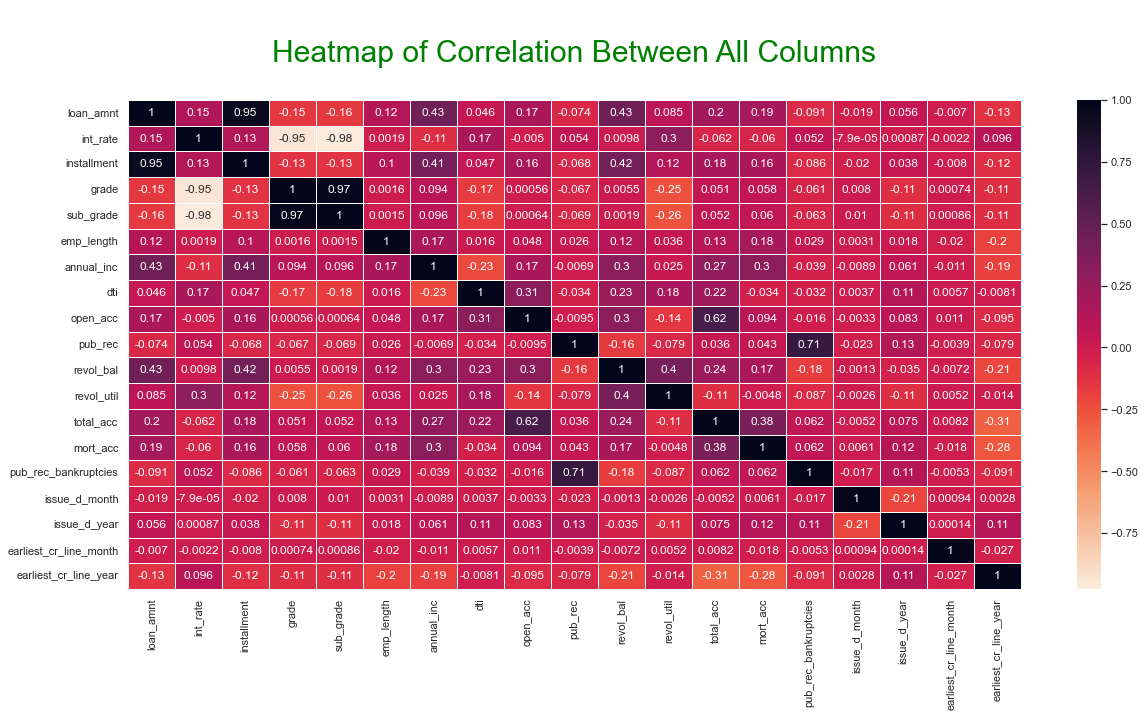

In [166]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

***
***
## **10. Hypothesis Testing to identify Significant Factors impacting the Loan status.**

In [167]:
charged_off = df[df['loan_status']=='Charged Off']
fully_paid = df[df['loan_status']=='Fully Paid']

***
***
### **A. Comparison of Loan status for different Interest Rates.**

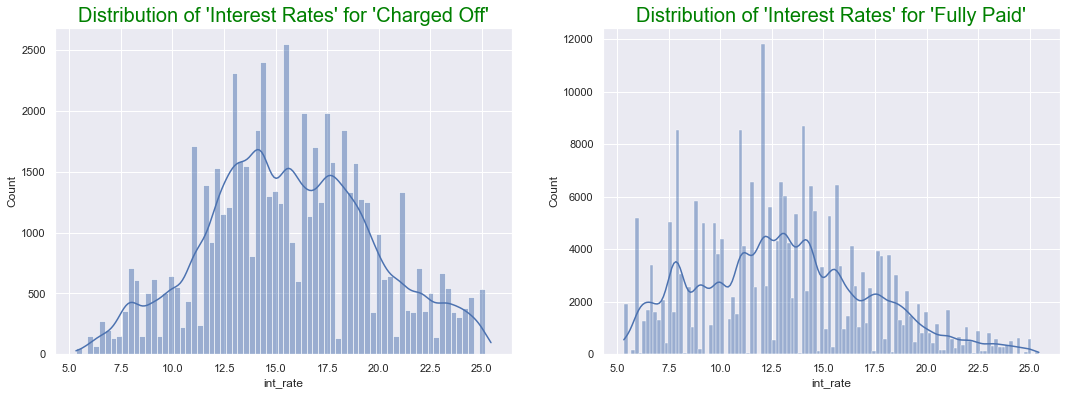

In [168]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(charged_off['int_rate'], kde=True, ax=axes[0]).set_title("Distribution of 'Interest Rates' for 'Charged Off'", fontsize=20, color="green")
sns.histplot(fully_paid['int_rate'], kde=True, ax=axes[1]).set_title("Distribution of 'Interest Rates' for 'Fully Paid'", fontsize=20, color="green")
plt.show()

***
### Even though, the distributions do not visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.

In [169]:
np.std(charged_off['int_rate'])**2, np.std(fully_paid['int_rate'])**2

(16.55900382647228, 17.302366851361707)

***
### Variances are roughly equal so proceeding further with 2 Sample T test.

***
### **Applying Unpaired T-Test**
***
### **H0** = The mean difference of 'Interest Rates' between unpaired observations for 'Charged Off and Paid Off' loans is zero.
### **H1** = The mean of 'Interest Rates' for unpaired observations of 'Charged Off' loans is grater than 'Paid Off' loans.

### **Significance Level (α)** = 0.05

In [170]:
stats.ttest_ind(charged_off['int_rate'].sample(100), fully_paid['int_rate'].sample(100), equal_var=False,  alternative='greater')

Ttest_indResult(statistic=3.720925222885863, pvalue=0.00012954920870784256)

***
### Rejected Null hypothesis. This means that Interest Rate has significant impact on Loan Status.

***
***
### **B. Comparison of Loan status for different Grades.**

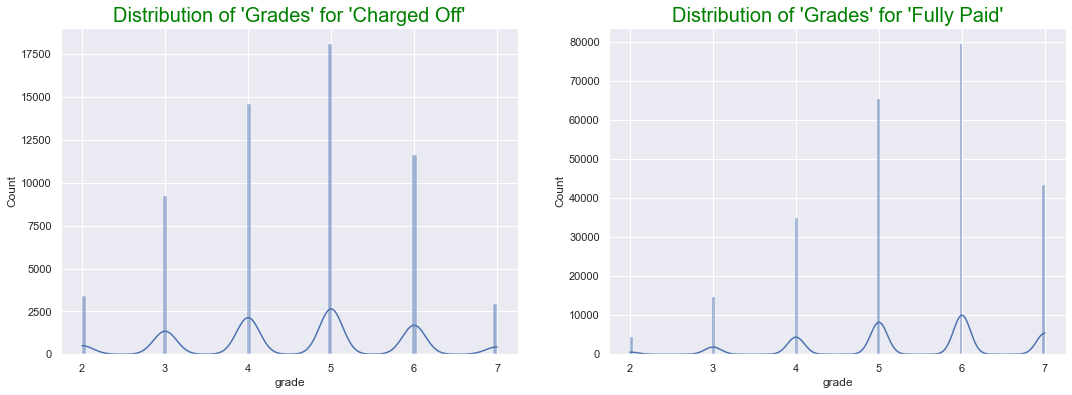

In [171]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(charged_off['grade'], kde=True, ax=axes[0]).set_title("Distribution of 'Grades' for 'Charged Off'", fontsize=20, color="green")
sns.histplot(fully_paid['grade'], kde=True, ax=axes[1]).set_title("Distribution of 'Grades' for 'Fully Paid'", fontsize=20, color="green")
plt.show()

***
### Even though, the distributions do not visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.

In [172]:
np.std(charged_off['grade'])**2, np.std(fully_paid['grade'])**2

(1.578433345363865, 1.4620525572433196)

***
### Variances are roughly equal so proceeding further with 2 Sample T test.

***
### **Applying Unpaired T-Test**
***
### **H0** = The mean difference of 'Grades' between unpaired observations for 'Charged Off and Paid Off' loans is zero.
### **H1** = The mean of 'Grades' for unpaired observations of 'Paid Off' loans is grater than 'Charged Off' loans.

### **Significance Level (α)** = 0.05

In [173]:
stats.ttest_ind(fully_paid['grade'].sample(100), charged_off['grade'].sample(100), equal_var=False,  alternative='greater')

Ttest_indResult(statistic=4.235907096023717, pvalue=1.7447340638104415e-05)

***
### Rejected Null hypothesis. This means that Grade has significant impact on Loan Status.

***
***
### **C. Comparison of Loan status for different Sub-Grades.**

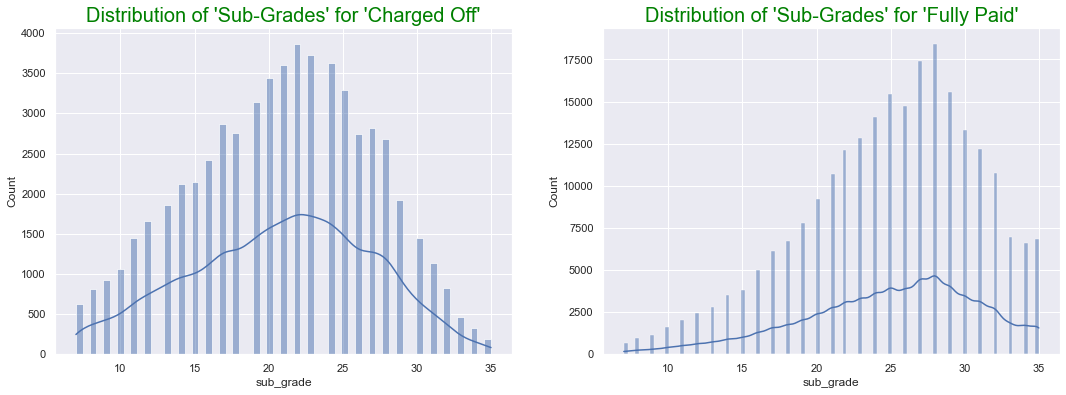

In [174]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(charged_off['sub_grade'], kde=True, ax=axes[0]).set_title("Distribution of 'Sub-Grades' for 'Charged Off'", fontsize=20, color="green")
sns.histplot(fully_paid['sub_grade'], kde=True, ax=axes[1]).set_title("Distribution of 'Sub-Grades' for 'Fully Paid'", fontsize=20, color="green")
plt.show()

***
### Even though, the distributions do not visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.

In [175]:
np.std(charged_off['sub_grade'])**2, np.std(fully_paid['sub_grade'])**2

(37.79473139681076, 35.67681363903408)

***
### Variances are roughly equal so proceeding further with 2 Sample T test.

***
### **Applying Unpaired T-Test**
***
### **H0** = The mean difference of 'Sub-Grades' between unpaired observations for 'Charged Off and Paid Off' loans is zero.
### **H1** = The mean of 'Sub-Grades' for unpaired observations of 'Paid Off' loans is grater than 'Charged Off' loans.

### **Significance Level (α)** = 0.05

In [176]:
stats.ttest_ind(fully_paid['sub_grade'].sample(100), charged_off['sub_grade'].sample(100), equal_var=False,  alternative='greater')

Ttest_indResult(statistic=5.0789004185949445, pvalue=4.416186589989915e-07)

***
### Rejected Null hypothesis. This means that Sub-Grade has significant impact on Loan Status.
***
***

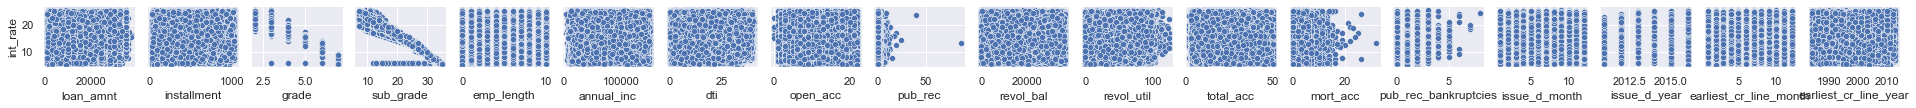

In [177]:
sns.pairplot(data=df, y_vars=["int_rate"], x_vars=[c for c in get_columns_by_types(df, numeric_types) if c != 'int_rate'], height=1.5, aspect=1);

***
### As seen from the pairplot, all significant factors (Interest Rate, Grade and Sub-Grade) are highly correlated with each other. So keeping only one column from them and dropping rest of the correlated significant factors.
***

In [178]:
df = df.drop(['int_rate', 'grade'], axis=1)

***
### In section 9, we can see that the Loan amount is highly correlated wth the Installments column. Hence we can drop the Installments column.
***

In [179]:
df = df.drop(['installment'], axis=1)

***
***
## **11. Feature Engineering and Feature Scaling.**

***
***
### **Applying One-Hot Encoding on Categorical Variables.**

In [180]:
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
df['loan_status'] = df['loan_status'].astype('int64')
df_old = df.copy()

In [181]:
for column in get_columns_by_types(df, categorical_types):
    if column == 'loan_status':
        continue
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop(column, inplace=True, axis=1)
    df.drop(df.columns[-1], inplace=True, axis=1)

***
***
### **Applying Target Encoding and Standard Scaling to the Train Data.**

In [182]:
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])

In [183]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1), df['loan_status'], random_state=0, test_size = .2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size = .2)

In [184]:
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)

D:\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
D:\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [185]:
X_train_columns=X_train.columns
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)

In [186]:
X_train.head()

,loan_amnt,sub_grade,emp_length,home_ownership,annual_inc,purpose,title,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,emp_title_primary,emp_title_secondary,pin_code,verification_status_Not Verified,verification_status_Source Verified,initial_list_status_f,application_type_DIRECT_PAY,application_type_INDIVIDUAL,term_months_36
0,-0.775609,1.114447,-0.699282,1.047646,-1.174670,-1.237449,0.178849,-0.441623,-0.117436,-0.340127,-0.333052,0.020494,-1.043773,-0.756224,-0.359415,-1.331215,-1.374279,-0.514749,0.296437,-0.029129,0.009915,-0.000479,1.400787,-0.713711,0.824901,-0.009651,0.032023,0.538273
1,-0.942585,-0.170233,-0.165318,1.047646,0.698589,0.914579,0.585671,1.034599,0.125265,-0.340127,-0.737273,0.057979,0.686769,-0.756224,-0.359415,1.014313,0.208734,-1.388933,0.643337,-1.986452,0.009915,-0.017970,-0.713884,-0.713711,-1.212266,-0.009651,0.032023,0.538273
2,1.005468,0.953862,1.169592,1.047646,-0.044937,0.438397,-3.595948,-0.121900,0.367966,-0.340127,0.020736,-1.353925,0.279582,-0.756224,-0.359415,1.014313,-0.582772,0.359436,-2.131858,0.369782,0.009915,0.021464,-0.713884,1.401128,0.824901,-0.009651,0.032023,-1.857792
3,-1.081732,0.632692,0.635628,1.047646,-1.048696,0.438397,-0.313823,-0.851269,-0.360137,-0.340127,-0.192804,0.170431,-1.247366,-0.756224,-0.359415,-0.451642,-0.582772,1.525015,0.643337,-0.044269,0.009915,-0.758900,1.400787,-0.713711,0.824901,-0.009651,0.032023,0.538273
4,-1.290452,-0.491403,1.169592,-1.039182,-0.155871,-1.112834,-0.084335,-1.454496,-0.845539,-0.340127,-0.050693,0.599417,-1.247366,-0.240555,-0.359415,-0.744833,-1.374279,0.650831,-0.397362,-0.044269,0.009915,-0.758900,1.400787,-0.713711,0.824901,-0.009651,0.032023,0.538273


In [187]:
X_train.shape, y_train.shape

((193275, 28), (193275,))

***
***
### **Applying Target Encoding and Standard Scaling to the Test and Validation Data.**

In [188]:
X_test = target_encoder.transform(X_test)
X_val = target_encoder.transform(X_val)

In [189]:
X_test_columns=X_test.columns
X_test_std=std.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)
X_val_columns=X_val.columns
X_val_std=std.transform(X_val)
X_val=pd.DataFrame(X_val_std, columns=X_val_columns)

***
***
## **12. Hyperparameter Tuning to decide best Regularization Parameter.**

In [190]:
train_scores = []
val_scores = []
for la in np.arange(0.01, 100000.0, 100):
    model= LogisticRegression(C=1/la)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)

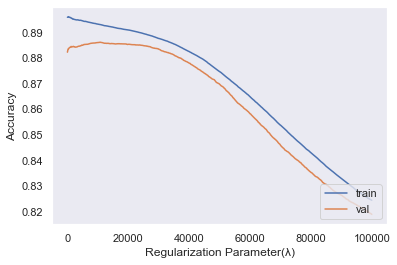

In [191]:
plt.figure()
plt.plot(list(np.arange(0.01, 100000.0, 100)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 100000.0, 100)), val_scores, label="val")
plt.legend(loc='lower right')

plt.xlabel("Regularization Parameter(λ)")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [192]:
np.max(val_scores), np.argmax(val_scores)

(0.8860696620377078, 108)

In [193]:
l_best = 0.01 + np.argmax(val_scores) * 100
l_best

10800.01

***
***
### **The best Regularization Parameter identified is 10800.01.**

***
***
## **13. Training the Logistic Regression model.**

In [194]:
model= LogisticRegression(C=1/l_best)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

In [195]:
print(f"Training Score is {round(train_score, 4)}")
print(f"Validation Score is {round(val_score, 4)}")
print(f"Test Score is {round(test_score, 4)}")

Training Score is 0.8929
Validation Score is 0.8861
Test Score is 0.8841


In [196]:
print(f"Model intercept is {model.intercept_}")

Model intercept is [-1.73048476]


In [197]:
pd.DataFrame(np.vstack([X_train.columns, model.coef_]).T, columns=['Feature', 'Model Coefficient']).sort_values(by='Model Coefficient', ascending=False)

,Feature,Model Coefficient
21,pin_code,1.021473
19,emp_title_primary,0.403993
6,title,0.209157
7,dti,0.118158
11,revol_util,0.087277
0,loan_amnt,0.065651
3,home_ownership,0.065553
8,open_acc,0.057822
24,initial_list_status_f,0.021197
26,application_type_INDIVIDUAL,0.017832


***
***
### **From the model coefficients we can deduce that 'pin_code' has the most impact on the 'Loan Status' followed by the 'Primary Employee Title' and 'Sub-Grade' features.**

***
***
## **14. Confusion Matrix.**

In [198]:
y_pred = model.predict(X_test)


Confusion Matrix
 [[48093   220]
 [ 6782  5304]] 



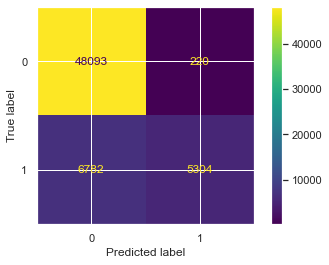

In [199]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

In [200]:
print(f"Precision Score is {precision_score(y_test, y_pred)}")
print(f"Recall Score is {recall_score(y_test, y_pred)}")
print(f"F1 Score is {f1_score(y_test, y_pred)}")

Precision Score is 0.9601737871107893
Recall Score is 0.43885487340724805
F1 Score is 0.6023850085178876


***
***
### **From the confusion matrix we can dedue that there are high number of False Negatives.**
### **Need to fix imbalance in target variable so as to reduce False Negatives.**

***
***
## **15. Treat Target Variable Imbalance.**

In [201]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [202]:
X_over, y_over = undersample.fit_resample(df_old.drop('loan_status', axis=1), df_old['loan_status'])

In [204]:
df = pd.concat([X_over, y_over], axis=1)

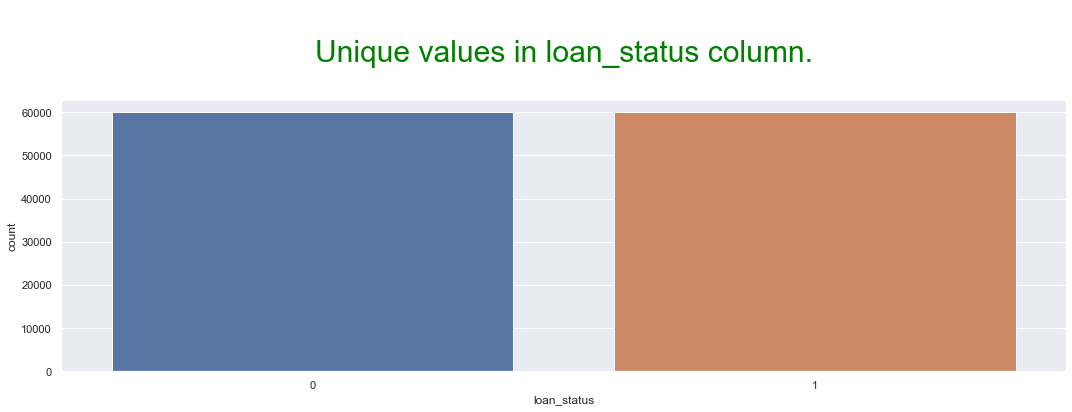

In [205]:
fig, axes = plt.subplots(figsize=(18,5))
sns.countplot(data=df, x='loan_status')
plt.title(f"\nUnique values in loan_status column.\n", fontsize=30, color="green")
plt.show()

***
***
## **16. Feature Engineering and Feature Scaling.**

In [206]:
for column in get_columns_by_types(df, categorical_types):
    if column == 'loan_status':
        continue
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop(column, inplace=True, axis=1)
    df.drop(df.columns[-1], inplace=True, axis=1)   

In [207]:
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])

In [208]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1), df['loan_status'], random_state=0, test_size = .2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size = .2)

In [209]:
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)

D:\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
D:\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [210]:
X_train_columns=X_train.columns
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)

In [211]:
X_test = target_encoder.transform(X_test)
X_val = target_encoder.transform(X_val)

In [212]:
X_test_columns=X_test.columns
X_test_std=std.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)
X_val_columns=X_val.columns
X_val_std=std.transform(X_val)
X_val=pd.DataFrame(X_val_std, columns=X_val_columns)

***
***
## **17. Hyperparameter Tuning to decide best Regularization Parameter.**

In [213]:
train_scores = []
val_scores = []
for la in np.arange(0.01, 100000.0, 100):
    model= LogisticRegression(C=1/la)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)

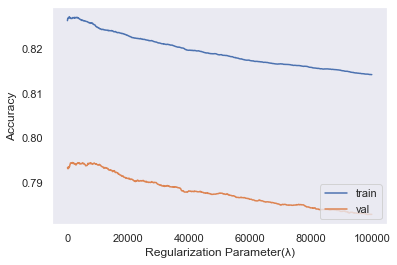

In [214]:
plt.figure()
plt.plot(list(np.arange(0.01, 100000.0, 100)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 100000.0, 100)), val_scores, label="val")
plt.legend(loc='lower right')

plt.xlabel("Regularization Parameter(λ)")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [215]:
np.max(val_scores), np.argmax(val_scores)

(0.7944748501433412, 17)

In [216]:
l_best = 0.01 + np.argmax(val_scores) * 100
l_best

1700.01

***
***
### **The best Regularization Parameter identified is 1700.01.**

***
***
## **18. Training the Logistic Regression model.**

In [217]:
model= LogisticRegression(C=1/l_best)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

In [218]:
print(f"Training Score is {round(train_score, 4)}")
print(f"Validation Score is {round(val_score, 4)}")
print(f"Test Score is {round(test_score, 4)}")

Training Score is 0.8269
Validation Score is 0.7945
Test Score is 0.7983


In [219]:
pd.DataFrame(np.vstack([X_train.columns, model.coef_]).T, columns=['Feature', 'Model Coefficient']).sort_values(by='Model Coefficient', ascending=False)

,Feature,Model Coefficient
21,pin_code,1.731746
19,emp_title_primary,0.540751
6,title,0.26269
7,dti,0.139236
11,revol_util,0.117298
8,open_acc,0.102606
0,loan_amnt,0.094672
3,home_ownership,0.084689
23,verification_status_Source Verified,0.031501
26,application_type_INDIVIDUAL,0.027951


***
***
### **From the model coefficients we can deduce that 'pin_code' has the most impact on the 'Loan Status' followed by the 'Primary Employee Title' and 'Loan Sub-Grade' features.**

***
***
## **19. Classification Report (Confusion Matrix).**

In [220]:
y_pred = model.predict(X_test)


Confusion Matrix
 [[9593 2298]
 [2538 9553]] 



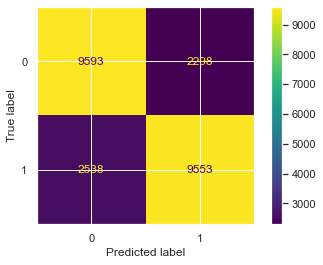

In [221]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

In [222]:
print(f"Precision Score is {precision_score(y_test, y_pred)}")
print(f"Recall Score is {recall_score(y_test, y_pred)}")
print(f"F1 Score is {f1_score(y_test, y_pred)}")

Precision Score is 0.8060923128849886
Recall Score is 0.790091803821024
F1 Score is 0.798011861999833


***
***
## **20. Precision-Recall Curve.**

In [223]:
y_score = model.predict_proba(X_test)[:, 1]

In [224]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

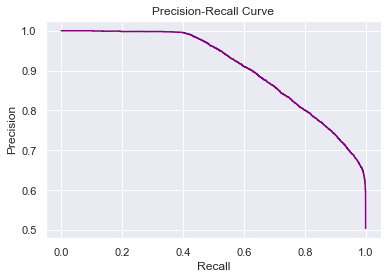

In [225]:
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [226]:
print(f"Area under precision Recall curve is {auc(recall, precision)}")

Area under precision Recall curve is 0.9089706578119627


***
***
## **21. ROC-AUC Curve.**

In [227]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

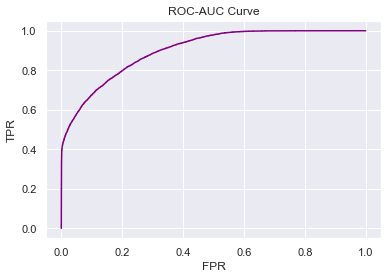

In [228]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='purple')
ax.set_title('ROC-AUC Curve')
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
plt.show()

In [229]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9014607020857953


***
***
## **22. Accuracy-Threshold Curve.**

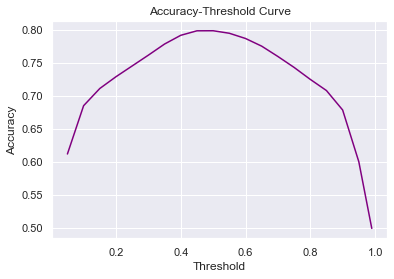

In [230]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [round((y_pred == y_test).sum()/y_pred.shape[0], 4)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('Accuracy-Threshold Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
plt.show()

In [231]:
np.max(scores), np.argmax(scores)

(0.7983, 9)

In [232]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.5


***
***
## **23. F1-Score-Threshold Curve.**

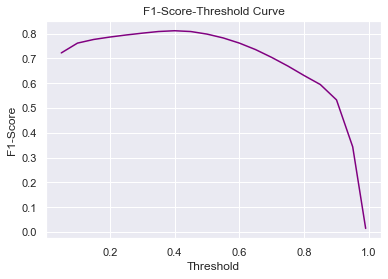

In [233]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [f1_score(y_test, y_pred)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('F1-Score-Threshold Curve')
ax.set_ylabel('F1-Score')
ax.set_xlabel('Threshold')
plt.show()

In [234]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9014607020857953


In [235]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.4


***
***
## **24. Tradeoff Questions.**

***
***
### A. How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.
### Ans:
#### 1. High number of False Positives or False Negatives can result from imbalance in the data. We have handled this case in section 15, by using undersampling technique to reduce imbalance in data.
#### 2. False Positives can be reduced and as a result model accuracy can be increased by choosing the best performing Regularization Parameter. We have handled this case in section 17, by using Hyperparameter Tuning.
#### 3. False Positives can also be reduced by increasing the threshold value. In the Accuracy-Threshold Curve we can see that the best performing threshold is 0.5 and if we increase our threshold value beyond that, the accuracy decreases. So, if we try to increase our threshold beyond 0.5, the number of False Positives might reduce but the number of False Nagatives will increase and True Positives will decrease.
#### For example, following is the Confusion Matrix resulted from using threshold value of 0.55 instead of 0.5.


Confusion Matrix
 [[10189  1702]
 [ 3226  8865]] 



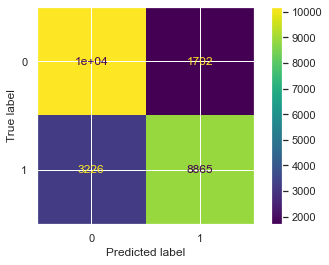

In [236]:
y_pred = np.vectorize(lambda x: 1 if x>0.55 else 0)(y_score)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

***
***
### B. Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.
### Ans:
#### 1. Not disbursing loans at all would stop earnings through the interests and might result in the stunted growth. The crux of the problem is high number of False nagatives. If we manage to reduce False Negatives significantly, we can bear minimum losses and still keep on disbursing loans.
#### 2. Steps to reduce False Nagatives are smilar to the steps we discussed for False Positive Reduction.
#### 3. False Nagatives can also be reduced by decreasing the threshold value. In the Accuracy-Threshold Curve we can see that the best performing threshold is 0.5 and if we decrease our threshold value beyond that, the accuracy decreases. So, if we try to decrease our threshold beyond 0.5, the number of False Negatives might reduce but the number of False Positives will increase and True Negatives will decrease.
#### For example, following is the Confusion Matrix resulted from using threshold value of 0.45 instead of 0.5.


Confusion Matrix
 [[ 8939  2952]
 [ 1887 10204]] 



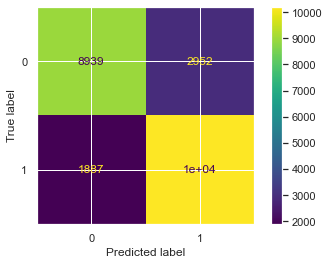

In [237]:
y_pred = np.vectorize(lambda x: 1 if x>0.45 else 0)(y_score)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

#### We just saw how decreasing False Positives might increase False Negatives. And decreasing False Negatives might increase False Positives. Since, the business wants to reduce both, we can
#### 1. Go with the optimal threshold value detected keeping the balance between False Positives and False Nagatives as it its.
#### 2. Go with another machine learning model which might yield better results.

***
***
## **25. Questionnaire.**

***
#### 1. What percentage of customers have fully paid their Loan Amount?

In [238]:
filename = 'logistic_regression.txt'
df = pd.read_csv(filename)
df['loan_status'].value_counts()/len(df)

Fully Paid     0.803871
Charged Off    0.196129
Name: loan_status, dtype: float64

#### Ans. 80.3%

***
#### 2. Comment about the correlation between Loan Amount and Installment features.

#### Ans. The correlation between Loan Amount and Installment is very high (0.95). Since, these columns would introduce multicollinearity, we have removed Installment column from our model.

***
#### 3. The majority of people have home ownership as _______.

In [239]:
df['home_ownership'].value_counts()/len(df)

MORTGAGE    0.500841
RENT        0.403480
OWN         0.095311
OTHER       0.000283
NONE        0.000078
ANY         0.000008
Name: home_ownership, dtype: float64

#### Ans. Mortgage.

***
#### 4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

In [240]:
df[df['loan_status']=='Fully Paid'].groupby(['grade'])['grade'].count()/df.groupby(['grade'])['grade'].count()

grade
A    0.937121
B    0.874270
C    0.788191
D    0.711322
E    0.626366
F    0.572120
G    0.521611
Name: grade, dtype: float64

#### Ans. True

***
#### 5. Name the top 2 afforded job titles.

In [241]:
df['emp_title'].value_counts().sort_values(ascending=False)

Teacher                         4389
Manager                         4250
Registered Nurse                1856
RN                              1846
Supervisor                      1830
                                ... 
NEW YORK HOSPITAL OF QUEENS        1
Famous Dave's of America           1
Sig LLC                            1
HARVEST PARTNERS, LP               1
Gracon Services, Inc               1
Name: emp_title, Length: 173105, dtype: int64

#### Ans. Teacher and Manager.

***
#### 6. Thinking from a bank's perspective, which metric should our primary focus be on.
#### ROC AUC
#### Precision
#### Recall
#### F1 Score

#### Ans. Thinking from a bank's perspective, our goal is to reduce both False Positives and False Negatives. Precision penalizes only the False Positives and Recall penalizes False Negatives. But, F1-Score takes into account both the Precision as well as Recall score. Hence, we should primarily focus on the F1-Score metric.

#### 7. How does the gap in precision and recall affect the bank?

#### Ans. Recall score is 0.79 and Precision score is 0.80. Which tells us that the number of False Positives is roughly same as the number of False Negatives. If Recall value is low (False Negatives are high), it means that the Bank is loosing in opportunity cost. If Precision value is low (False Positives are high), it means that the Bank's NPA (defaulters) may increase.

#### 8. Which were the features that heavily affected the outcome?

In [249]:
c = pd.DataFrame(np.vstack([X_train.columns, np.abs(model.coef_)]).T, columns=['Feature', 'Model Coefficient']).sort_values(by='Model Coefficient', ascending=False)
c.head()

,Feature,Model Coefficient
21,pin_code,1.731746
19,emp_title_primary,0.540751
1,sub_grade,0.365513
6,title,0.26269
27,term_months_36,0.190402


#### Ans. Pin Code is the most significant feature followed by emp_title_primary, sub_grade, title, term_months_36. Since, we removed Grade and Interest Rate which were highly correlated with sub_grade, they're also equally significant features.

#### 9. Will the results be affected by geographical location? (Yes/No)

#### Ans. Yes. The results are highly affected by Pin Code.

***
***
## **26. Business Insights.**
#### **A.** Majority of the applications of are type Individual.
#### **B.** Most loans are for term length 36 months instead of 60 months.
#### **C.** Loans with higher interest rates have more cases of defaulting.
#### **D.** Loans with higher Grades/Sub-Grades have less cases of defaulting.
#### **E.** Most of the loans funded after 2014 have initial list status as W instead of F.
#### **F.** Loans with Direct Pay applications have higher interest rates, higer dti ratio and lower grades/sub_grades.
#### **G.** Loans with tenure of 60 months have higher loan amounts, higher interest rates, but lower grades/sub-grades.
#### **H.** Grade, Sub-Grade and Interest Rates have very high correlation between them.
#### **I.** Logistic Regression Model with the imbalanced data has high accuracy of .88, high precision of 0.96 but low recall score of 0.43.
#### **J.** After fixing imbalanced data, we get slightly lower accuracy of 0.79, lower precision of 0.80, but we get much higher recall score of 0.79, improving our model significantly.
#### **K.** F1 Score before fixing imbalance was 0.60, but after fixing imbalance we get F1 Score of 0.79.
#### **L.** Area under ROC-AUC curve is 90%.
#### **M.** The best Regularization Parameter (lambda) identified for our model is 1700.01..

***
***
## **27. Recommendations.**
#### **A.** To predict Loan Status, the columns pin_code, emp_title_primary, int_rate, grade sub_grade, title, term_months_36 should be considered.
#### **B.** While disbursing loans, banks should check address and locality of a person since some geographical locations have higher rates of defaulting compared to others.
#### **C.** While disbursing loans, banks should also check profession of a person since some professions have higher rates of defaulting compared to others.
#### **D.** Loantap designated Grade and Sub-Grade to the loan has high impact on loan status. So the banks should avoid disbursing loans with bad grade or sub-grade.
#### **F.** Factors such as Monthly income, age, current debt should also be considered and tested for their effect on the 'Loan Status' for improving the prediction model.